# Prerequisites

In [1]:
import numpy as np
import pandas as pd
from tm import StockDataProvider
from tm.trading_rules import SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender
from tm.optimizers import GeneticOptimizer, StrategyPerformanceEvaluator, map_chromosome_to_trading_rule_parameters, filter_for_active_rules, calculate_absolute_buy_and_hold_returns
from tm.backtesting import GeometricBrownianMotion, MonteCarloCrossValidation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Define the trading rule basis for the strategy.

In [2]:
trading_rules = [SimpleMovingAverage, ExponentialMovingAverage, STO, MACD, RSI, ROC, BollingerBaender]

Define a function which finds the best strategy by running the genetic algorithm and applying backtesting.

In [3]:
# Returns best strategy as bitvector
def find_best_strategy(ticker_name, start, end, ngen=7):
    data = StockDataProvider(ticker_name, start=start, end=end)
    optimizer = GeneticOptimizer(data, trading_rules, random_seed=42)
    print('Running genetic algorithm ...')
    hof = optimizer.run(pop_size=1000, ngen=ngen, hof_size=100, mutpb=0.3)
    print('Net profit of buy and hold:', calculate_absolute_buy_and_hold_returns(data))
    gbm = GeometricBrownianMotion(data)
    crossvalidator = MonteCarloCrossValidation(hof, gbm, trading_rules)
    print('Running backtesting ...')
    best_individual = crossvalidator.run(num_iterations=100, time_steps=85)
    del data
    del optimizer
    del gbm
    del crossvalidator    
    return best_individual

Define a function which prints the results for the testing period.

In [4]:
def print_test_results(individual, ticker_name, start, end):
    real_data = StockDataProvider(ticker_name, start=start, end=end)
    rule_instances = list(map(lambda Rule, params: Rule(real_data, *params), trading_rules, map_chromosome_to_trading_rule_parameters(individual, trading_rules)))
    active_rule_instances = filter_for_active_rules(individual, rule_instances)
    evaluator = StrategyPerformanceEvaluator(active_rule_instances)
    net_profit, last_sell = evaluator.calculate_net_profit()
    net_profit_bh = calculate_absolute_buy_and_hold_returns(real_data, early_out=last_sell)
    percentage_profit = net_profit / real_data.history['Close'].iloc[0] * 100
    percentage_profit_bh = net_profit_bh / real_data.history['Close'].iloc[0] * 100
    print('Active rules:', list(map(lambda rule: rule.__class__.__name__, active_rule_instances)))
    print('Active rules\' parameters:', list(map(lambda param: param[1], filter(lambda param: trading_rules[param[0]] in map(lambda rule: rule.__class__, active_rule_instances), enumerate(map_chromosome_to_trading_rule_parameters(individual, trading_rules))))))
    print('Net profit of strategy: {:f}'.format(net_profit))
    print('Net profit of buy and hold: {:f}'.format(net_profit_bh))
    print('Percentage profit of strategy: {:f}%'.format(percentage_profit))
    print('Percentage profit of buy and hold: {:f}%'.format(percentage_profit_bh))
    print('Number of buy signals:', len(evaluator.buy_signals[evaluator.buy_signals == True]))
    print('Number of sell signals:', len(evaluator.sell_signals[evaluator.sell_signals == True]))
    del real_data
    return evaluator, percentage_profit, percentage_profit_bh

Define a function which can plot a strategy.

In [5]:
def plot_strategy(evaluator, ticker_name, start, end):
    data = StockDataProvider(ticker_name, start=start, end=end)
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(data.history['Close'], label='Stock prices')

    if len(evaluator.buy_signals[evaluator.buy_signals == True]) > 0:
        buy_points = pd.Series(data=map(lambda index, price: price if evaluator.buy_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=buy_points.index, y=buy_points, color='green', marker='^', label='Buy signal')
    
    if len(evaluator.sell_signals[evaluator.sell_signals == True]) > 0:
        sell_points = pd.Series(data=map(lambda index, price: price if evaluator.sell_signals.loc[index] == True else np.nan, data.history['Close'].index, data.history['Close']),
                               index=data.history['Close'].index)
        ax.scatter(x=sell_points.index, y=sell_points, color='red', marker='v', label='Sell signal')

    ax.set_xlabel('Date')
    ax.set_ylabel('Stock price')
    ax.legend()
    fig.tight_layout()
    del data

# Experiments

In [6]:
results = {'EXS1.DE': [],
           'ADS.DE': [],
           'ALV.DE': [],
           'BAS.DE': [],
           'DBK.DE': [],
           'DTE.DE': [],
           'SAP.DE': [],
           'DJI': [],
           'CSCO': [],
           'DD': [],
           'JPM': [],
           'MSFT': [],
           'NKE': [],
           'UNH': []}

## DAX

In [7]:
%%time
best_individual = find_best_strategy(ticker_name='EXS1.DE', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-114.454	23.9327	-28.2259	20.2025
1  	635   	-112.792	23.9327	-14.3714	14.3661
2  	649   	-113.777	26.5922	-5.53739	12.2477
3  	617   	-112.792	27.1181	0.174579	11.7739
4  	691   	-112.802	29.9115	3.37352 	12.2177
5  	666   	-112.792	29.6461	6.4182  	13.4024
6  	655   	-112.792	30.5859	8.71274 	14.6552
7  	648   	-112.082	35.0095	11.738  	13.7625
Net profit of buy and hold: 1.519725000000013
Running backtesting ...
Best individual: [0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1]
Best average net profit: 1.648486905948364
CPU times: user 5min 12s, sys: 354 ms, total: 5min 12s
Wall time: 5min 12s


In [8]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')
results['EXS1.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[13, 45, 63], [30, 6]]
Net profit of strategy: 18.924125
Net profit of buy and hold: 21.888200
Percentage profit of strategy: 20.759242%
Percentage profit of buy and hold: 24.010750%
Number of buy signals: 6
Number of sell signals: 6


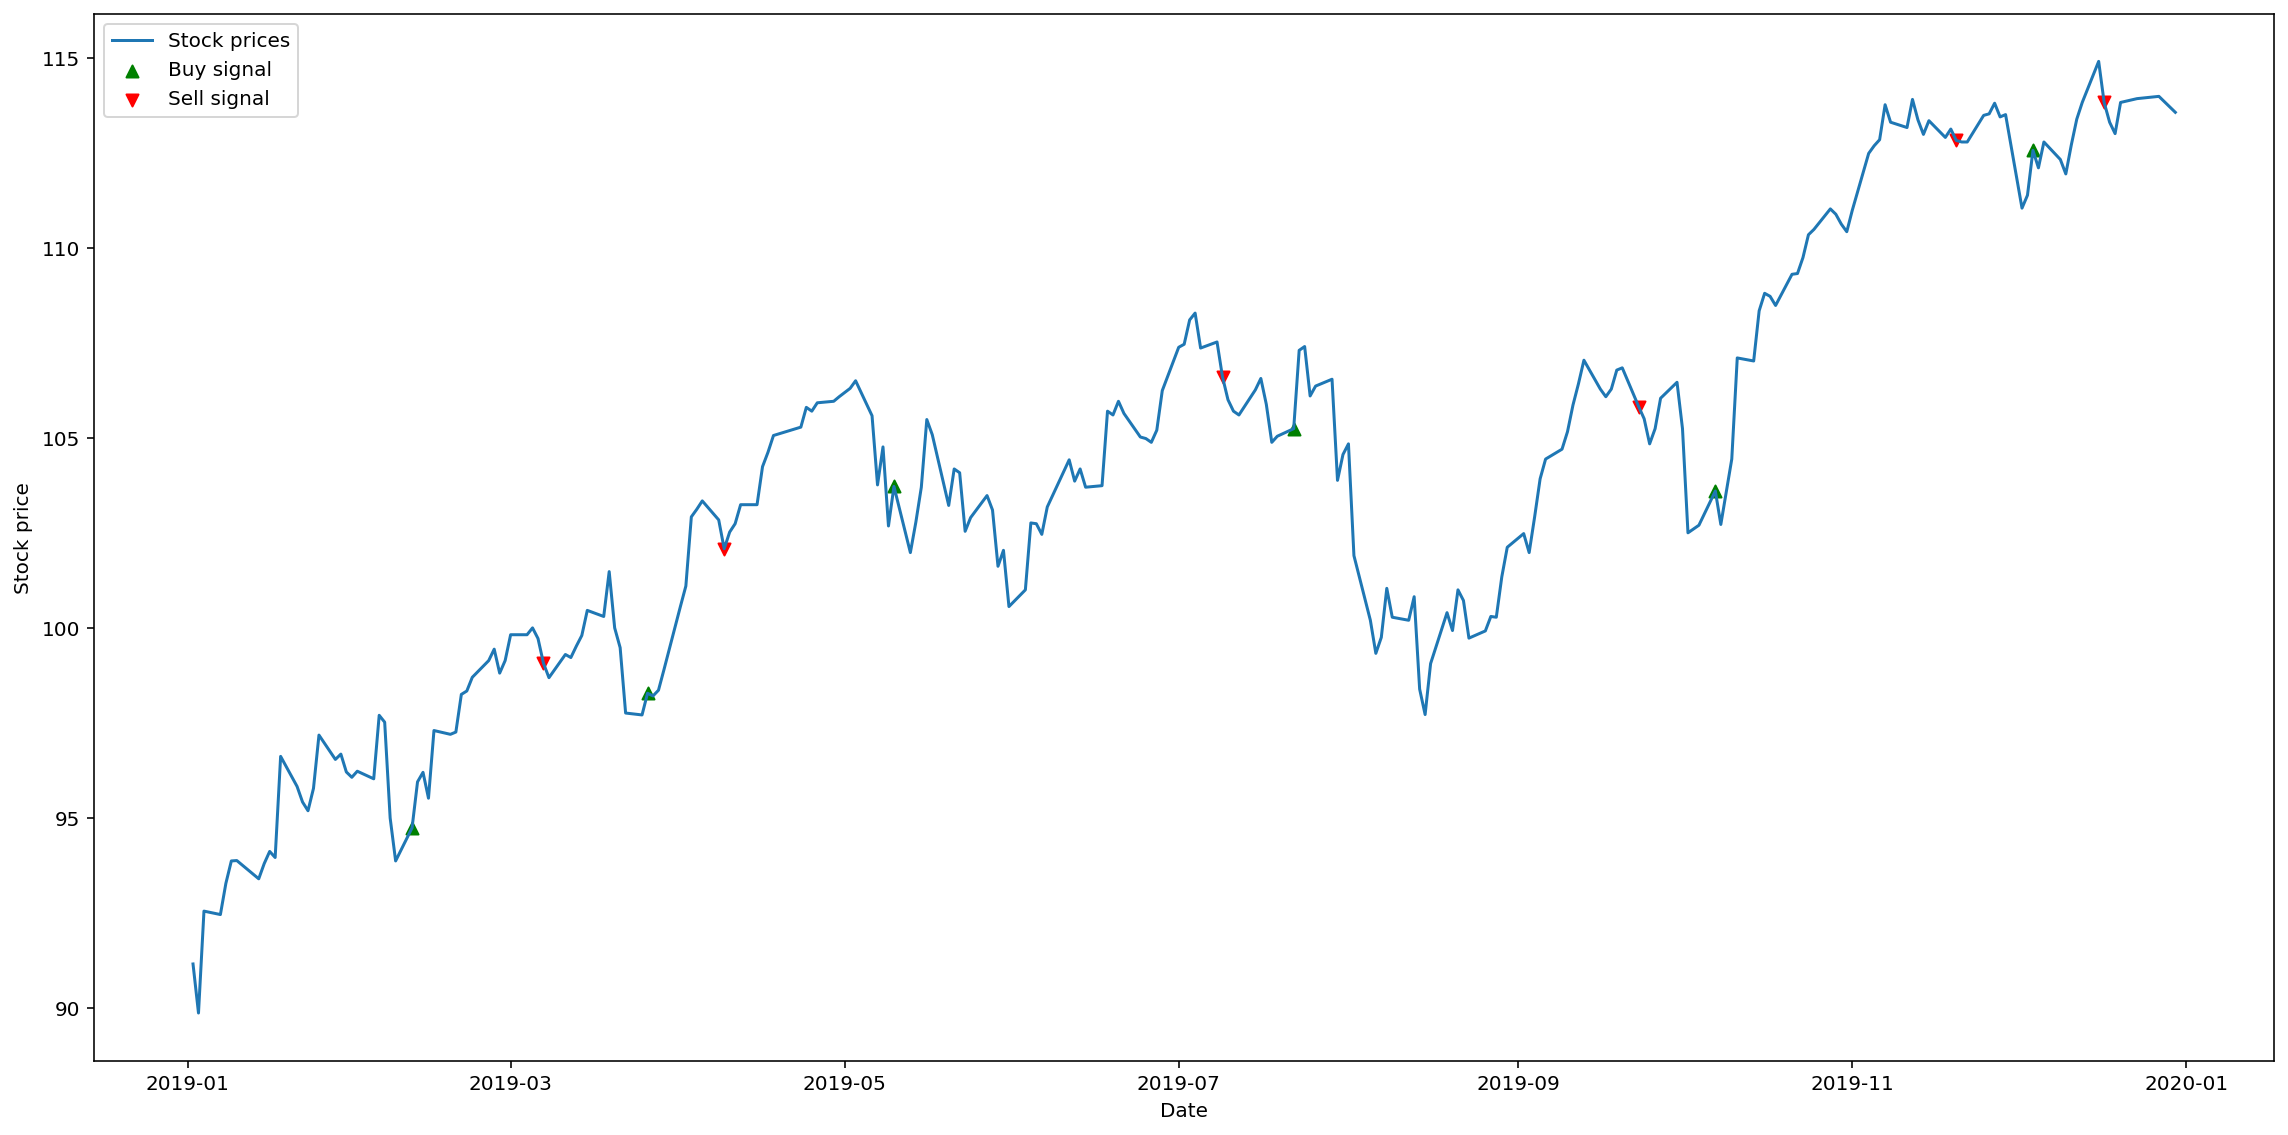

In [9]:
plot_strategy(evaluator, ticker_name='EXS1.DE', start='2019-01-01', end='2019-12-31')

## Adidas

In [10]:
%%time
best_individual = find_best_strategy(ticker_name='ADS.DE', start='2016-01-01', end='2018-12-31', ngen=7)

/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/phipag/miniconda3/envs/trading_machine/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-143.818	87.7008	-2.14077	37.2825
1  	635   	-94.767 	94.9349	22.1693 	27.6953
2  	649   	-140.631	100.753	38.0203 	25.5347
3  	617   	-135.621	112.373	49.9754 	26.6035
4  	691   	-59.2996	109.274	59.5591 	23.9997
5  	666   	-122.286	108.334	67.1111 	23.4121
6  	655   	-130.781	111.392	72.3061 	23.4722
7  	648   	-139.944	114.546	74.0504 	27.7304
Net profit of buy and hold: 95.468225
Running backtesting ...
Best individual: [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0]
Best average net profit: 0.09916097118815267
CPU times: user 5min 28s, sys: 297 ms, total: 5min 29s
Wall time: 5min 29s


In [11]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')
results['ADS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'MACD', 'RSI', 'BollingerBaender']
Active rules' parameters: [[162], [31, 53, 37], [47, 11, 58], [40, 6]]
Net profit of strategy: 38.457125
Net profit of buy and hold: 88.304750
Percentage profit of strategy: 21.563937%
Percentage profit of buy and hold: 49.514831%
Number of buy signals: 5
Number of sell signals: 5


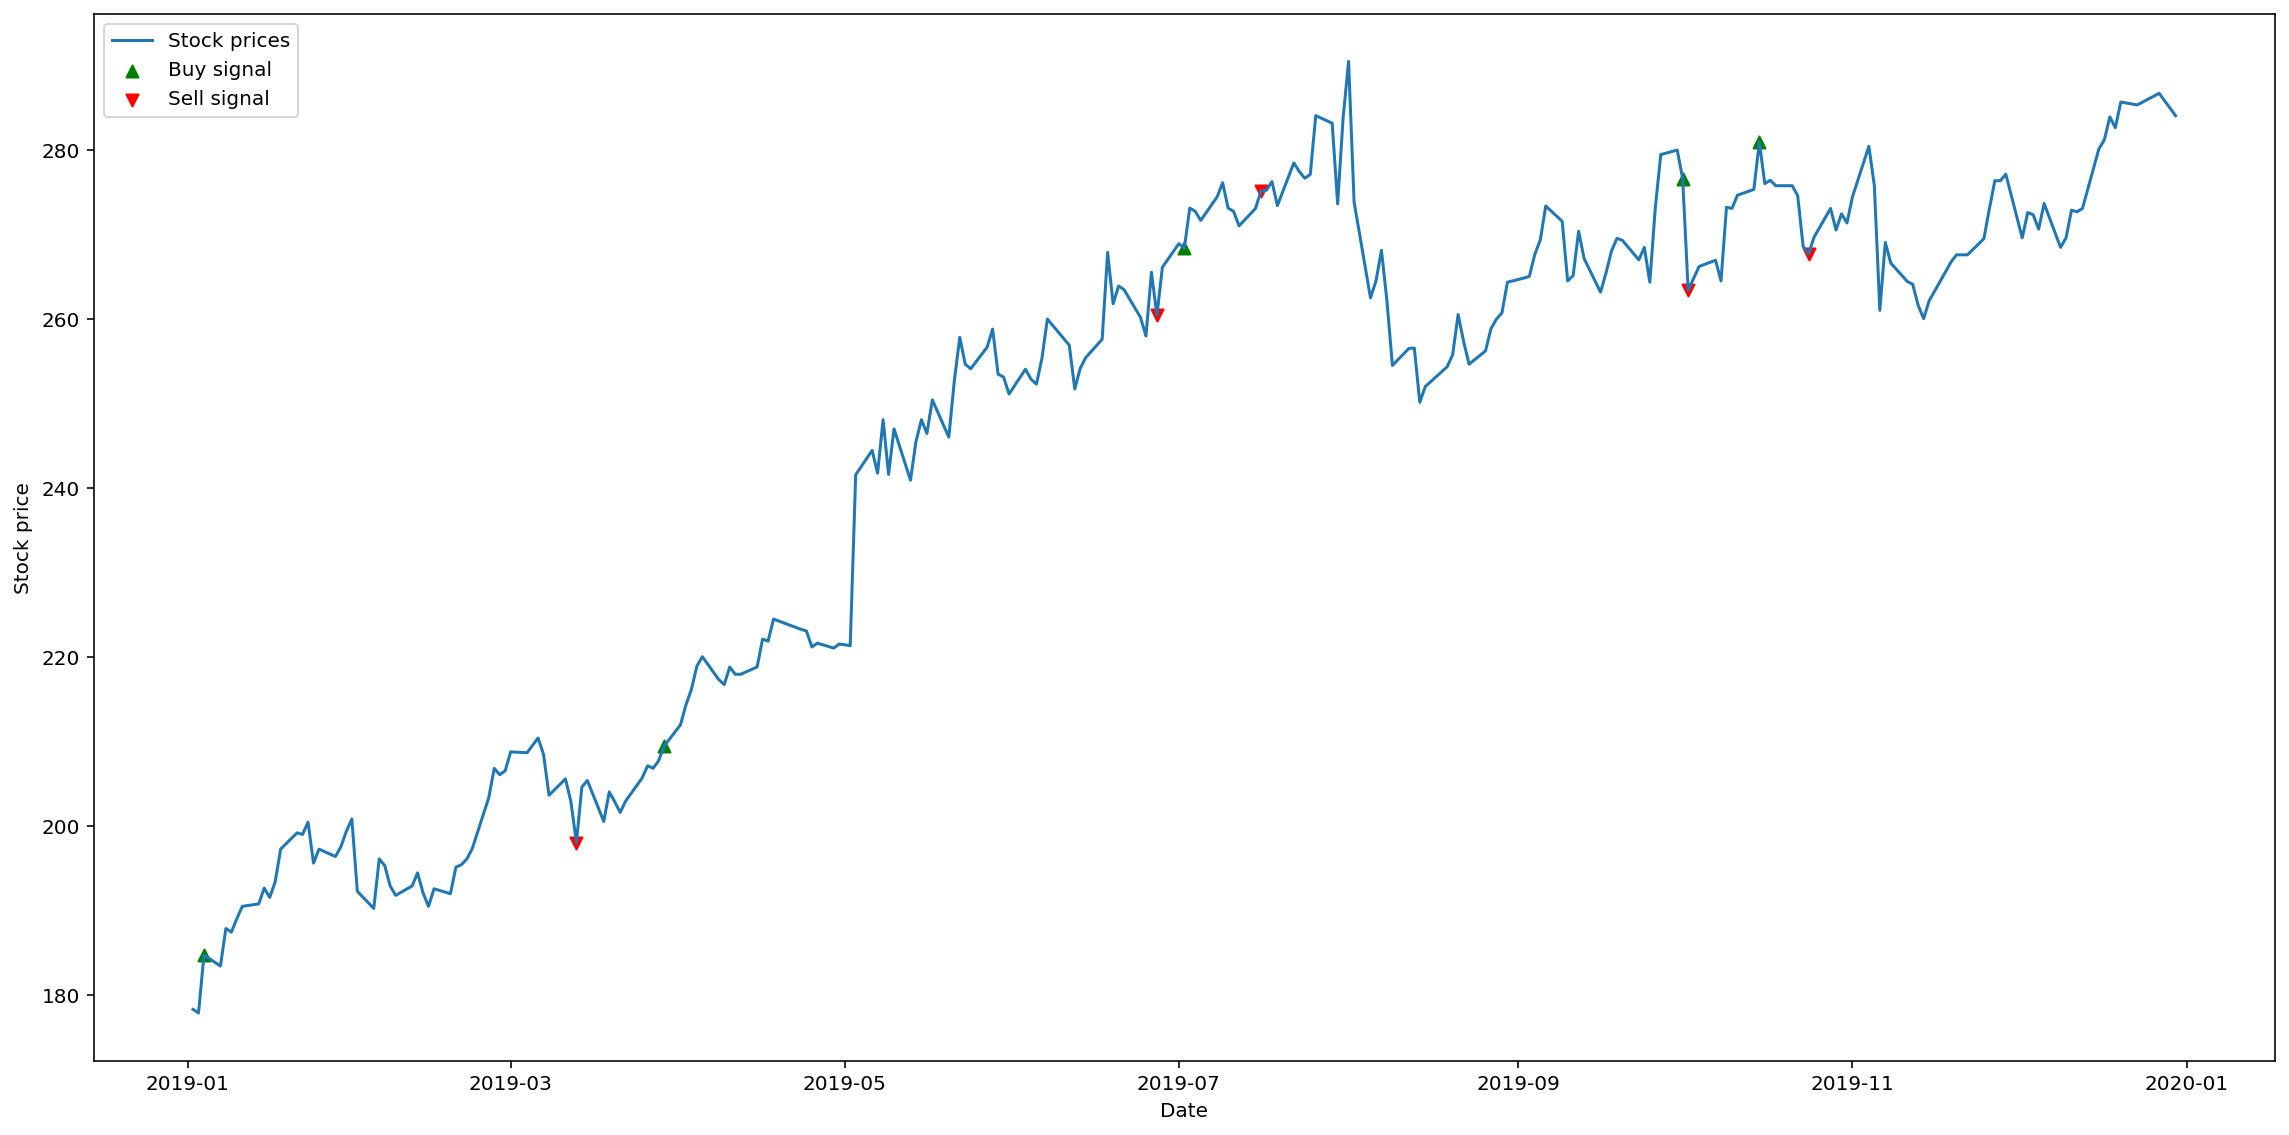

In [12]:
plot_strategy(evaluator, ticker_name='ADS.DE', start='2019-01-01', end='2019-12-31')

## Allianz

In [13]:
%%time
best_individual = find_best_strategy(ticker_name='ALV.DE', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std    
0  	1000  	-136.913	36.4341	-19.528	23.5509
1  	635   	-117.509	46.317 	-4.53488	17.021 
2  	649   	-122.379	51.261 	5.1232  	17.2803
3  	617   	-68.055 	57.8708	13.416  	16.5236
4  	691   	-40.5963	60.4795	19.9988 	16.8123
5  	666   	-117.509	58.7426	25.3595 	18.5506
6  	655   	-120.501	68.9423	30.3768 	19.2676
7  	648   	-117.509	72.3091	35.2951 	20.1617
Net profit of buy and hold: 40.68527499999999
Running backtesting ...
Best individual: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0]
Best average net profit: 5.092537802674951
CPU times: user 4min 56s, sys: 253 ms, total: 4min 56s
Wall time: 4min 56s


In [14]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')
results['ALV.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[10, 42, 104], [152], [20, 7]]
Net profit of strategy: 17.657825
Net profit of buy and hold: 49.157325
Percentage profit of strategy: 11.211317%
Percentage profit of buy and hold: 31.211000%
Number of buy signals: 3
Number of sell signals: 3


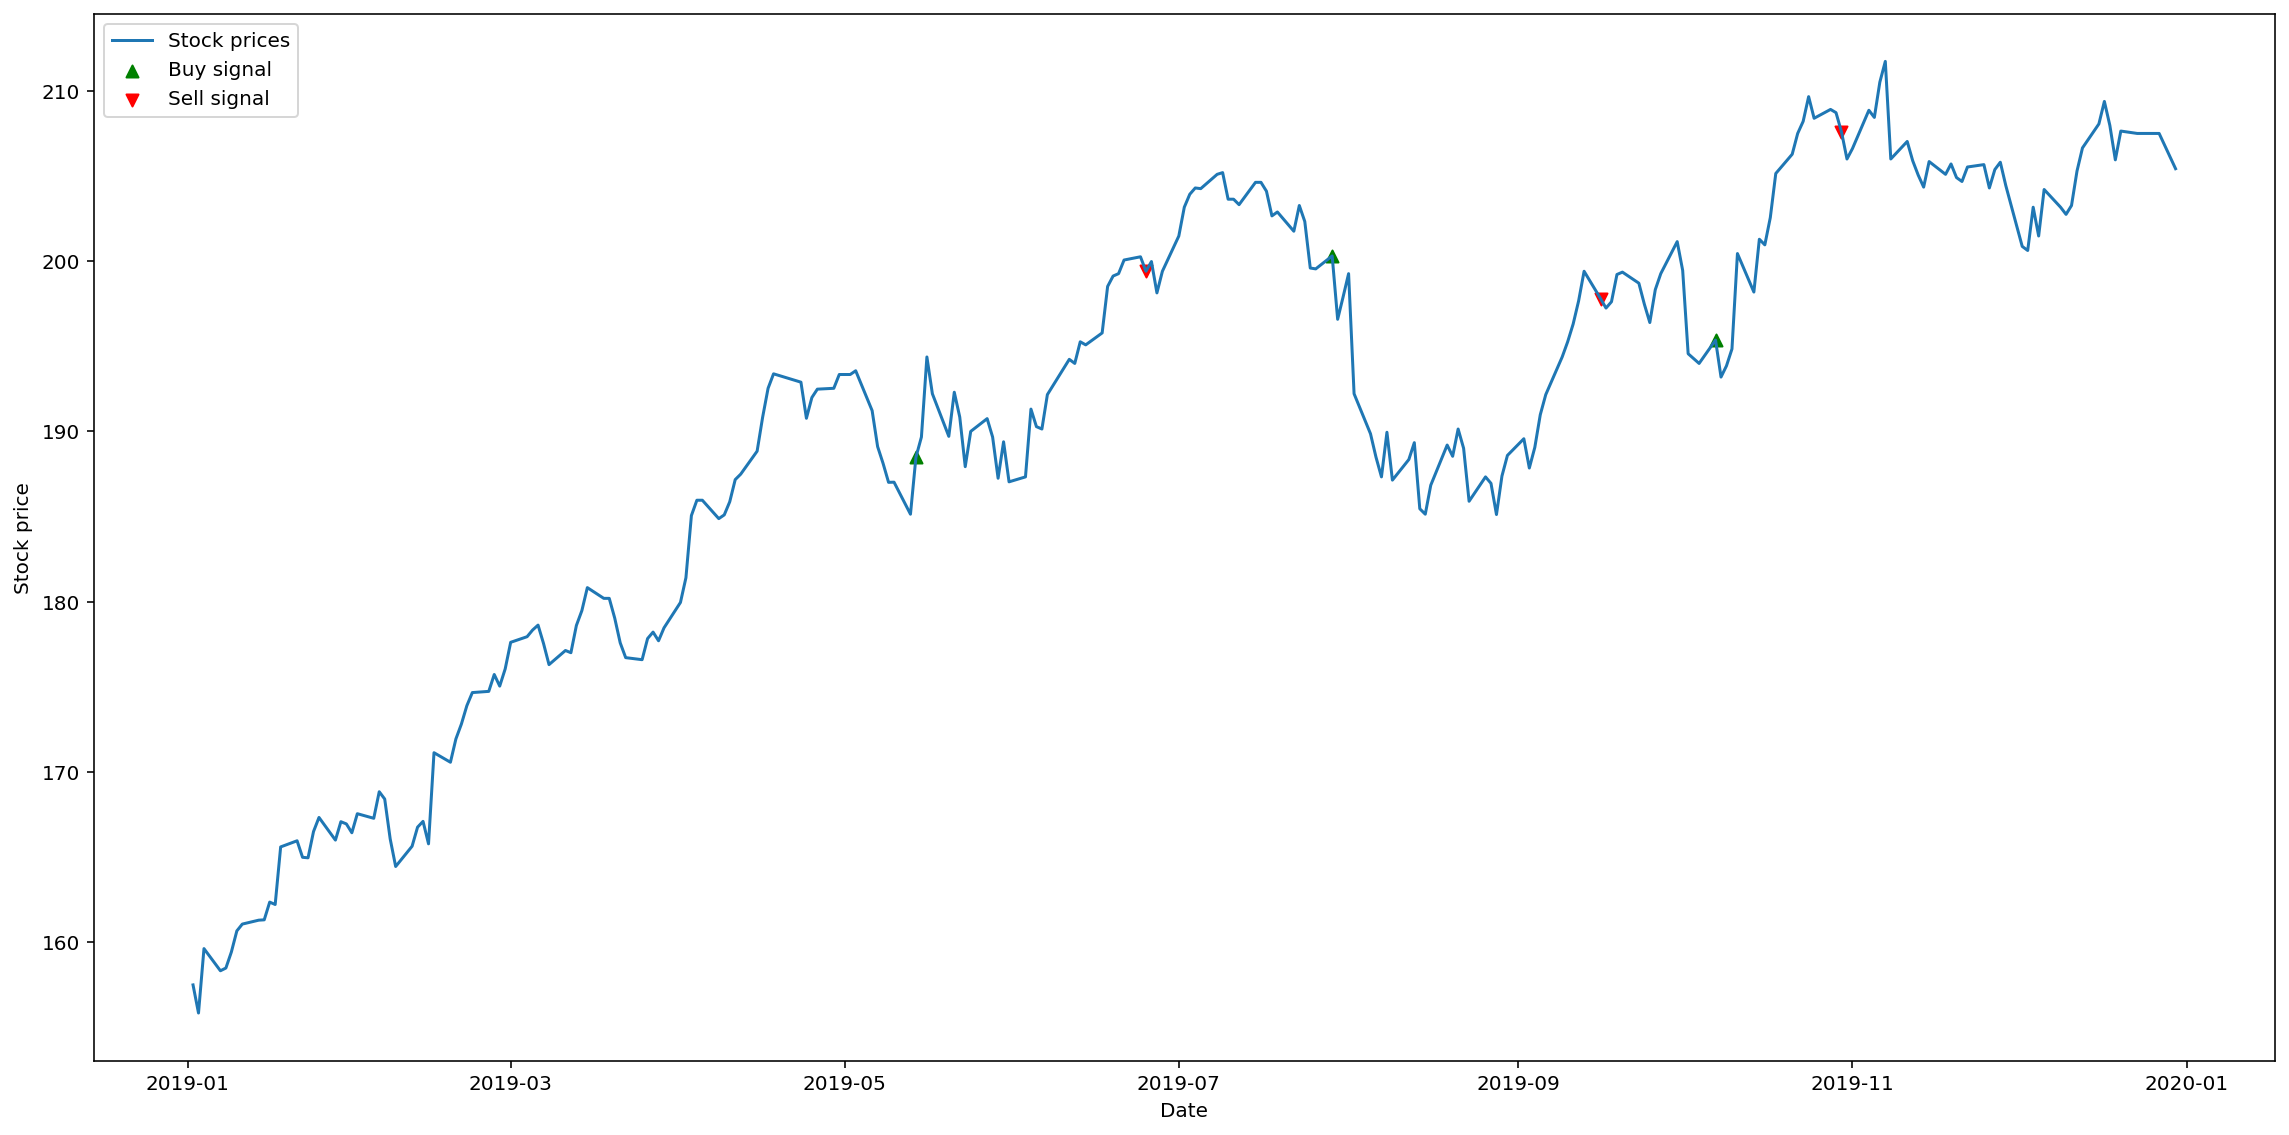

In [15]:
plot_strategy(evaluator, ticker_name='ALV.DE', start='2019-01-01', end='2019-12-31')

## BASF

In [16]:
%%time
best_individual = find_best_strategy(ticker_name='BAS.DE', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean   	std   
0  	1000  	-62.1208	20.5618	-10.952	12.672
1  	635   	-36.4104	20.5618	-2.53877	8.65772
2  	649   	-58.7963	26.3784	2.47617 	8.06415
3  	617   	-59.4267	34.2278	5.82679 	8.24744
4  	691   	-59.4267	34.2278	8.02249 	9.22751
5  	666   	-59.8532	34.2278	9.76455 	9.10282
6  	655   	-60.532 	34.2278	11.1867 	10.9125
7  	648   	-58.7963	34.8322	12.6983 	11.4561
Net profit of buy and hold: -0.29204999999999914
Running backtesting ...
Best individual: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0]
Best average net profit: 0.5816892392357157
CPU times: user 5min 50s, sys: 419 ms, total: 5min 50s
Wall time: 5min 50s


In [17]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')
results['BAS.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'RSI', 'BollingerBaender']
Active rules' parameters: [[189], [5, 109, 109], [9, 3]]
Net profit of strategy: 4.594700
Net profit of buy and hold: 5.442475
Percentage profit of strategy: 9.071471%
Percentage profit of buy and hold: 10.745262%
Number of buy signals: 7
Number of sell signals: 7


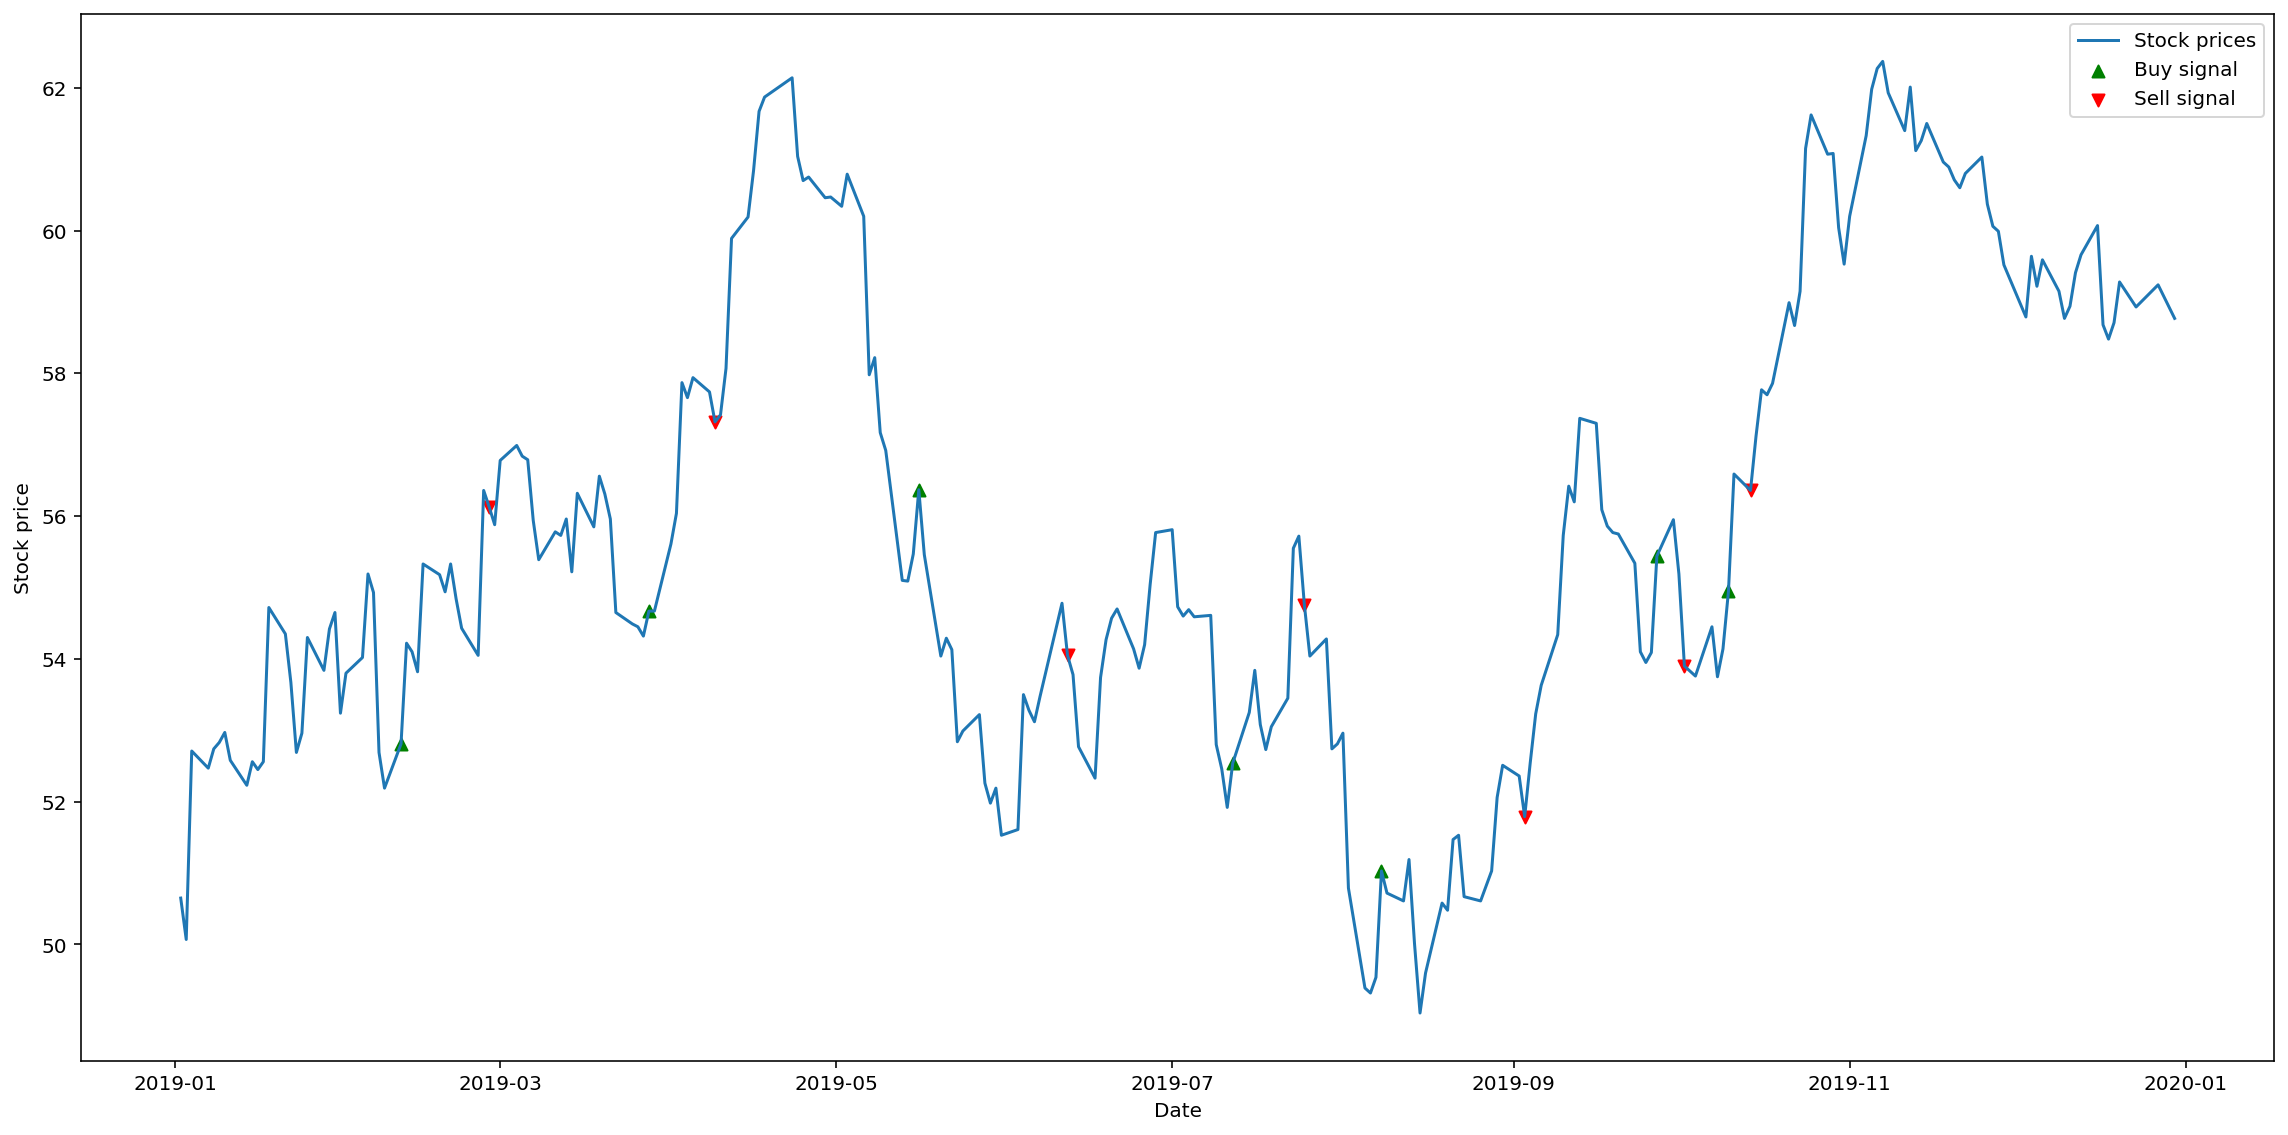

In [18]:
plot_strategy(evaluator, ticker_name='BAS.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Bank

In [19]:
%%time
best_individual = find_best_strategy(ticker_name='DBK.DE', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-14.0746	3.31872	-4.30784	3.37731
1  	635   	-12.1884	4.39885	-2.02089	2.63988
2  	649   	-12.4808	4.39885	-0.67171	2.37128
3  	617   	-11.3591	4.55573	0.257573	2.22945
4  	691   	-11.2105	4.39885	0.780643	2.24109
5  	666   	-12.5197	5.83988	1.14919 	2.43515
6  	655   	-9.61888	6.04503	1.71167 	2.30156
7  	648   	-12.1428	6.8437 	2.10456 	2.42134
Net profit of buy and hold: -11.62315
Running backtesting ...
Best individual: [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]
Best average net profit: 0.005682131245329247
CPU times: user 6min 5s, sys: 475 ms, total: 6min 5s
Wall time: 6min 5s


In [20]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')
results['DBK.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['SimpleMovingAverage', 'STO', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[73], [194], [8, 113, 125], [216], [37, 0]]
Net profit of strategy: 2.358975
Net profit of buy and hold: -0.144875
Percentage profit of strategy: 33.555832%
Percentage profit of buy and hold: -2.060811%
Number of buy signals: 9
Number of sell signals: 9


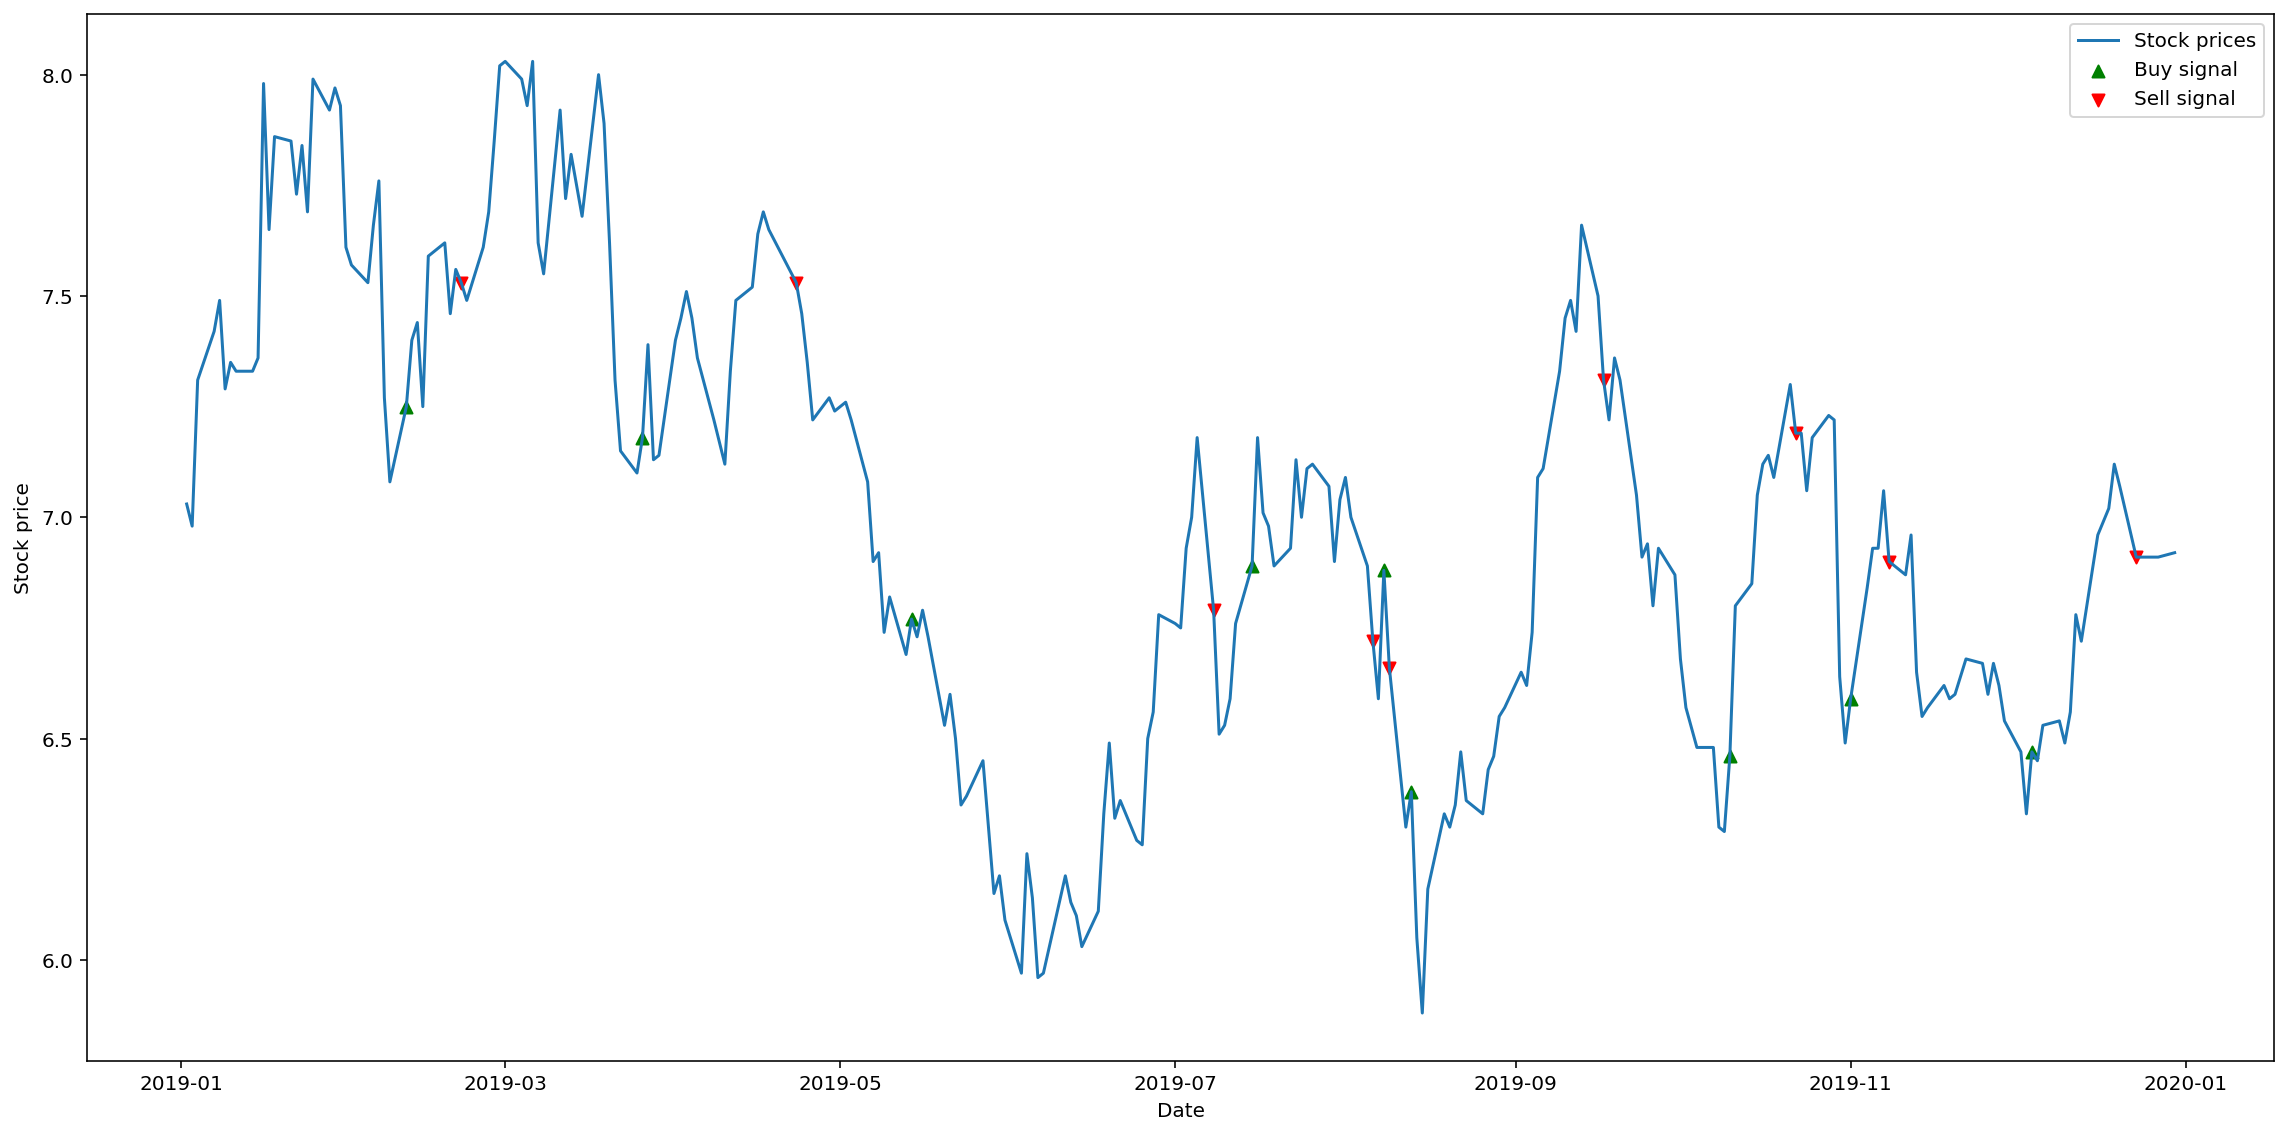

In [21]:
plot_strategy(evaluator, ticker_name='DBK.DE', start='2019-01-01', end='2019-12-31')

## Deutsche Telekom

In [22]:
%%time
best_individual = find_best_strategy(ticker_name='DTE.DE', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-10.6442	2.22698	-3.01095	2.14637
1  	635   	-7.8002 	3.22443	-1.4786 	1.61771
2  	649   	-9.63277	3.22443	-0.517646	1.2783 
3  	617   	-9.63277	2.64247	0.0521913	1.19246
4  	691   	-6.73362	2.9545 	0.333817 	1.09975
5  	666   	-9.63277	3.85638	0.529181 	1.35849
6  	655   	-9.65193	4.60045	0.670271 	1.37307
7  	648   	-9.88953	4.76988	0.940521 	1.47987
Net profit of buy and hold: 1.6496749999999991
Running backtesting ...
Best individual: [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1]
Best average net profit: 0.3120211749165593
CPU times: user 6min 10s, sys: 496 ms, total: 6min 10s
Wall time: 6min 10s


In [23]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')
results['DTE.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[11, 43, 111], [29, 6]]
Net profit of strategy: 1.583725
Net profit of buy and hold: 1.611200
Percentage profit of strategy: 12.257933%
Percentage profit of buy and hold: 12.470588%
Number of buy signals: 3
Number of sell signals: 3


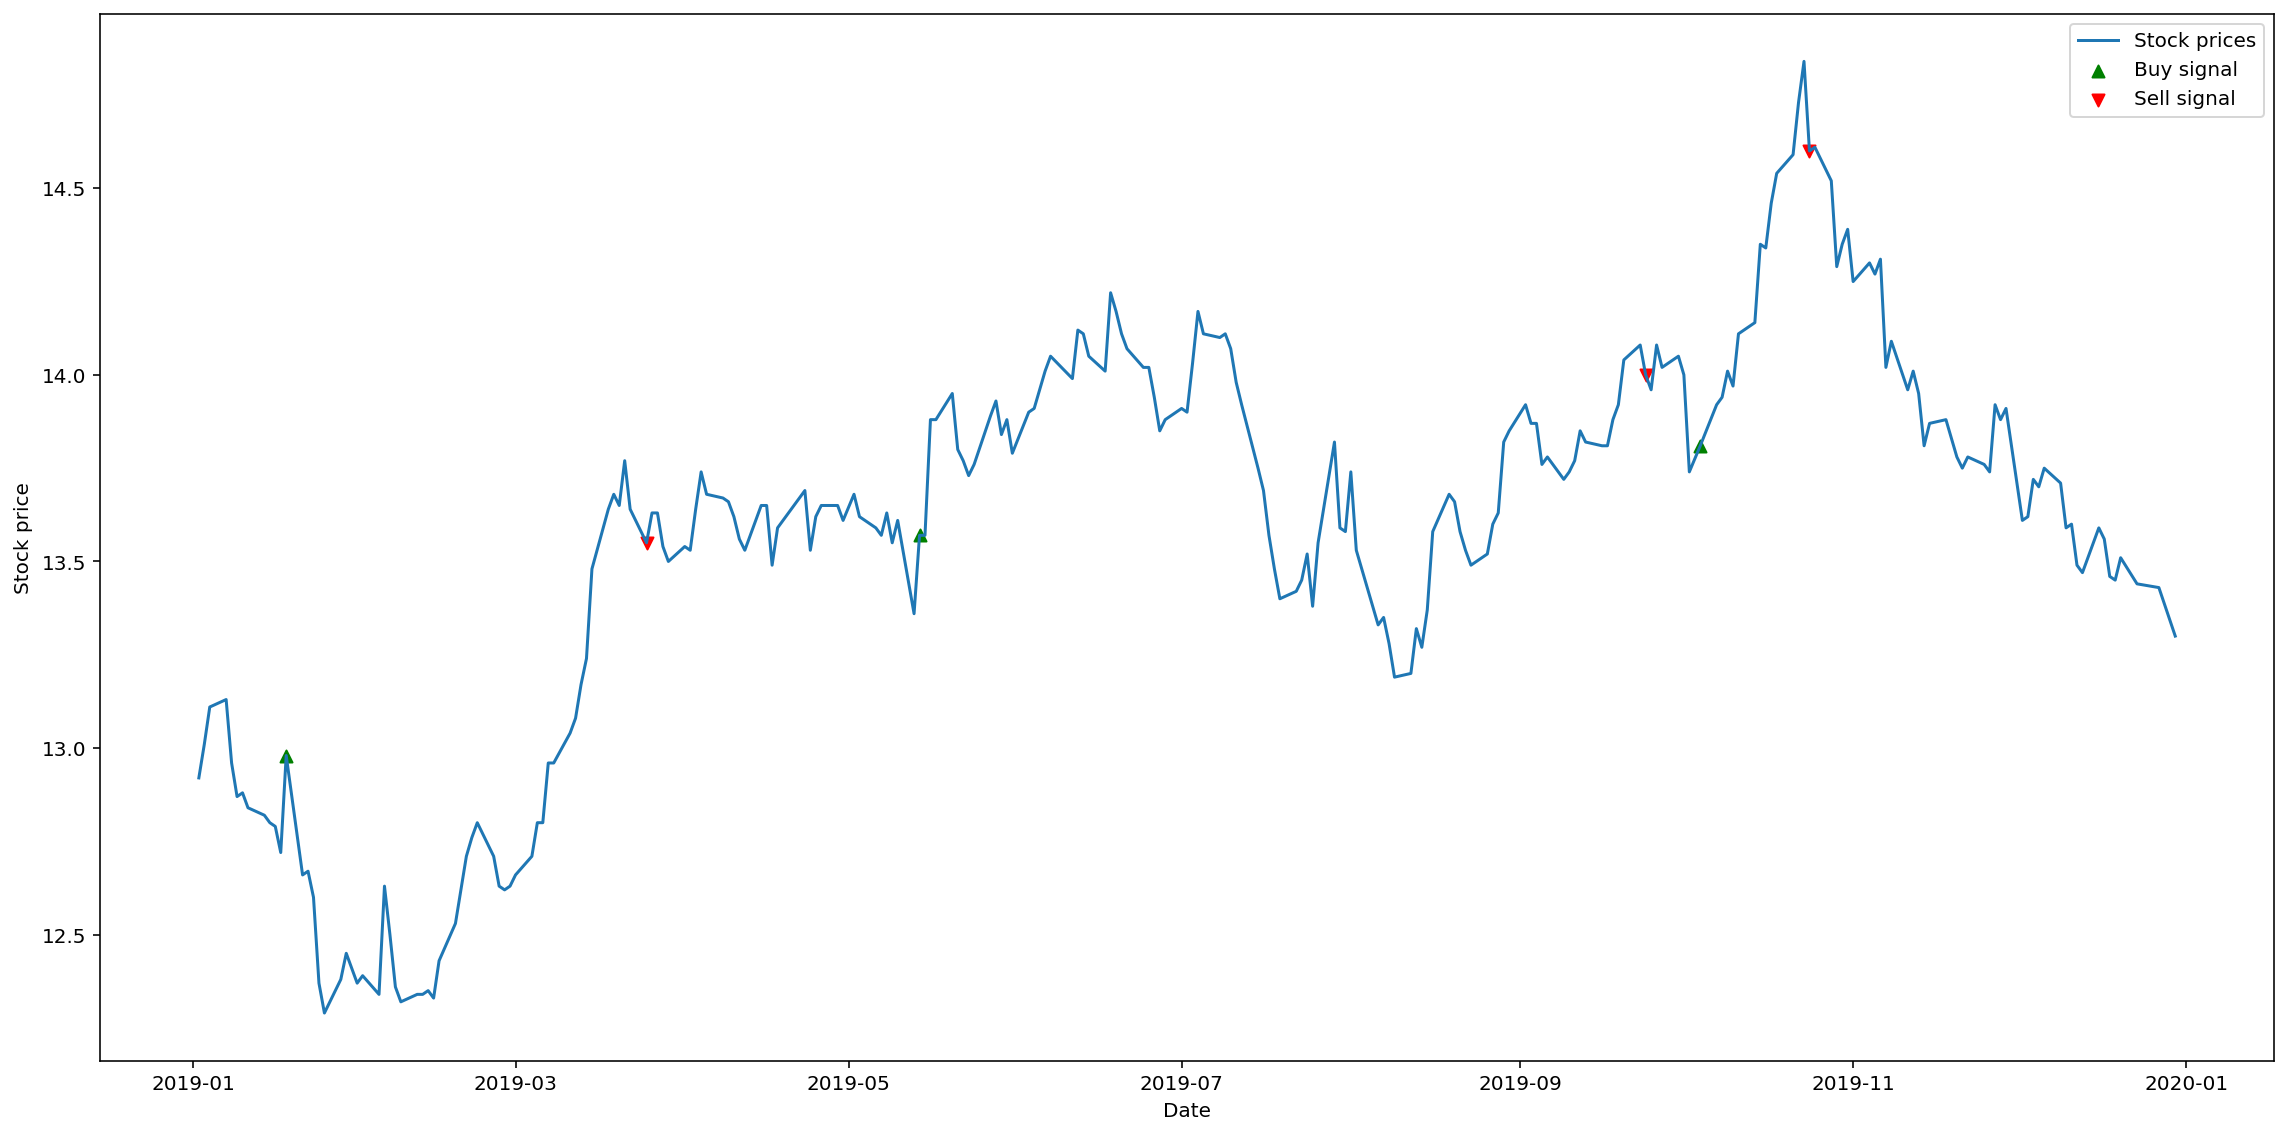

In [24]:
plot_strategy(evaluator, ticker_name='DTE.DE', start='2019-01-01', end='2019-12-31')

## SAP

In [25]:
%%time
best_individual = find_best_strategy(ticker_name='SAP.DE', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-76.3482	26.2995	-12.7614	16.7432
1  	635   	-75.559 	26.5262	-1.56201	11.8749
2  	649   	-72.5756	30.1153	4.98534 	9.9914 
3  	617   	-72.9649	33.2496	9.01721 	9.47856
4  	691   	-75.3969	34.3959	12.1265 	10.3822
5  	666   	-75.559 	40.4849	14.4061 	11.3255
6  	655   	-72.5756	41.9025	16.4067 	11.5778
7  	648   	-75.559 	40.5522	17.7861 	13.7094
Net profit of buy and hold: 18.250100000000003
Running backtesting ...
Best individual: [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Best average net profit: 0.6147652917776617
CPU times: user 5min 43s, sys: 491 ms, total: 5min 43s
Wall time: 5min 43s


In [26]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')
results['SAP.DE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[31, 59, 111], [25, 6]]
Net profit of strategy: 9.706550
Net profit of buy and hold: 23.952075
Percentage profit of strategy: 11.642737%
Percentage profit of buy and hold: 28.729849%
Number of buy signals: 1
Number of sell signals: 1


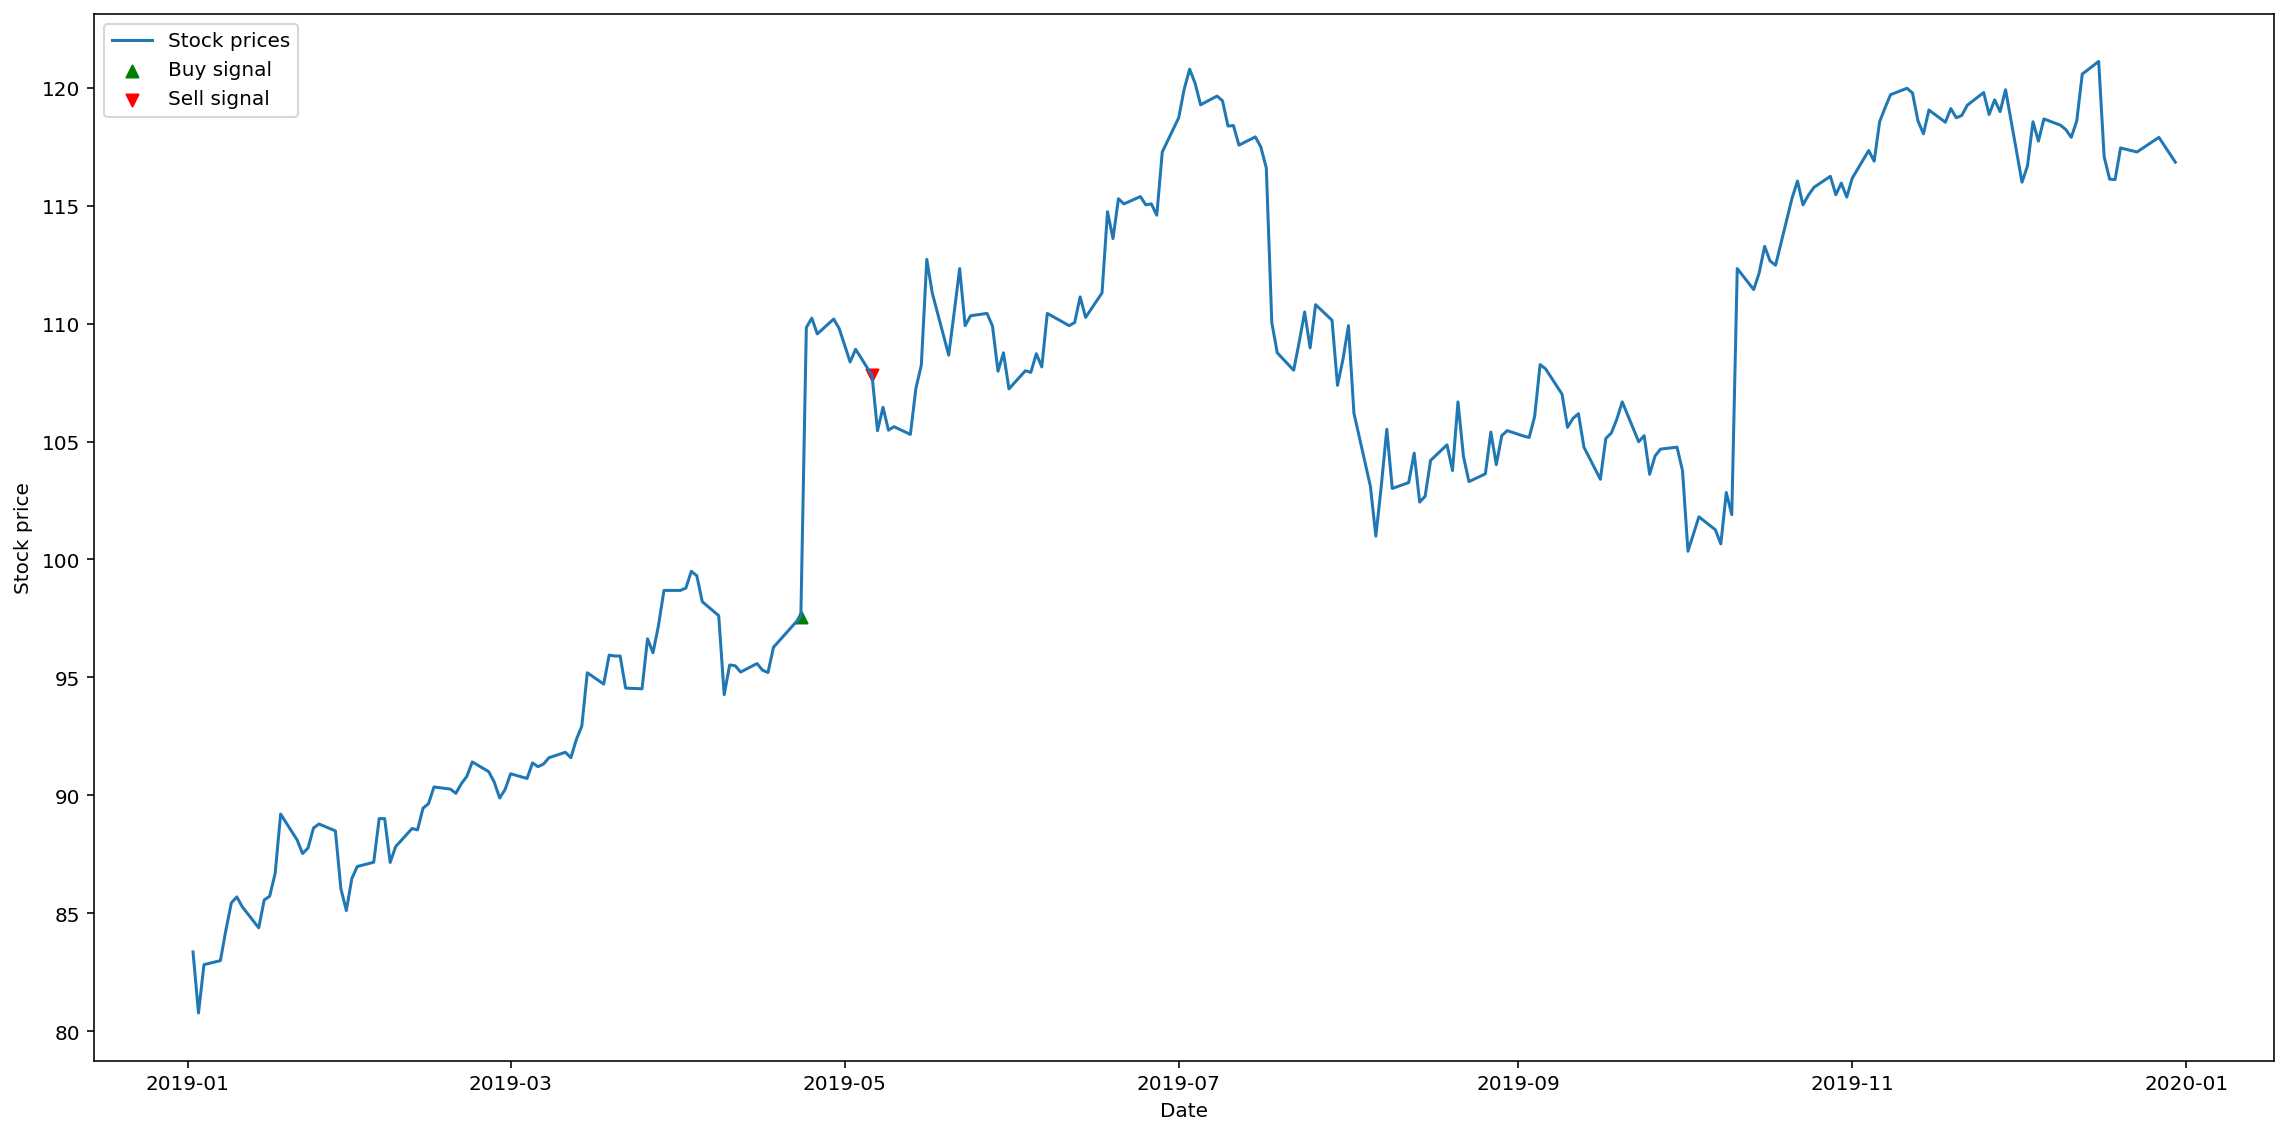

In [27]:
plot_strategy(evaluator, ticker_name='SAP.DE', start='2019-01-01', end='2019-12-31')

## Dow Jones Index

In [28]:
%%time
best_individual = find_best_strategy(ticker_name='DJI', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min   	max    	mean    	std    
0  	1000  	-16062	9004.29	-404.421	3345.05
1  	635   	-9499.24	9004.29	1594.46 	1991.18
2  	649   	-14277.9	9004.29	2610.89 	1922.75
3  	617   	-14277.9	9004.29	3356.05 	2043.06
4  	691   	-14277.9	9004.29	3786.94 	2213.42
5  	666   	-14604.2	9004.29	4300.04 	2200.53
6  	655   	-7290.77	10136.5	4724.51 	2193.12
7  	648   	-8030.49	10136.5	5072.98 	2282.5 
Net profit of buy and hold: 5812.97175
Running backtesting ...
Best individual: [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1]
Best average net profit: 258.11675685659134
CPU times: user 6min 4s, sys: 514 ms, total: 6min 4s
Wall time: 6min 4s


In [29]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DJI', start='2019-01-01', end='2019-12-31')
results['DJI'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[16, 59, 79], [25, 6]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 2519.888500
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 10.796114%
Number of buy signals: 0
Number of sell signals: 0


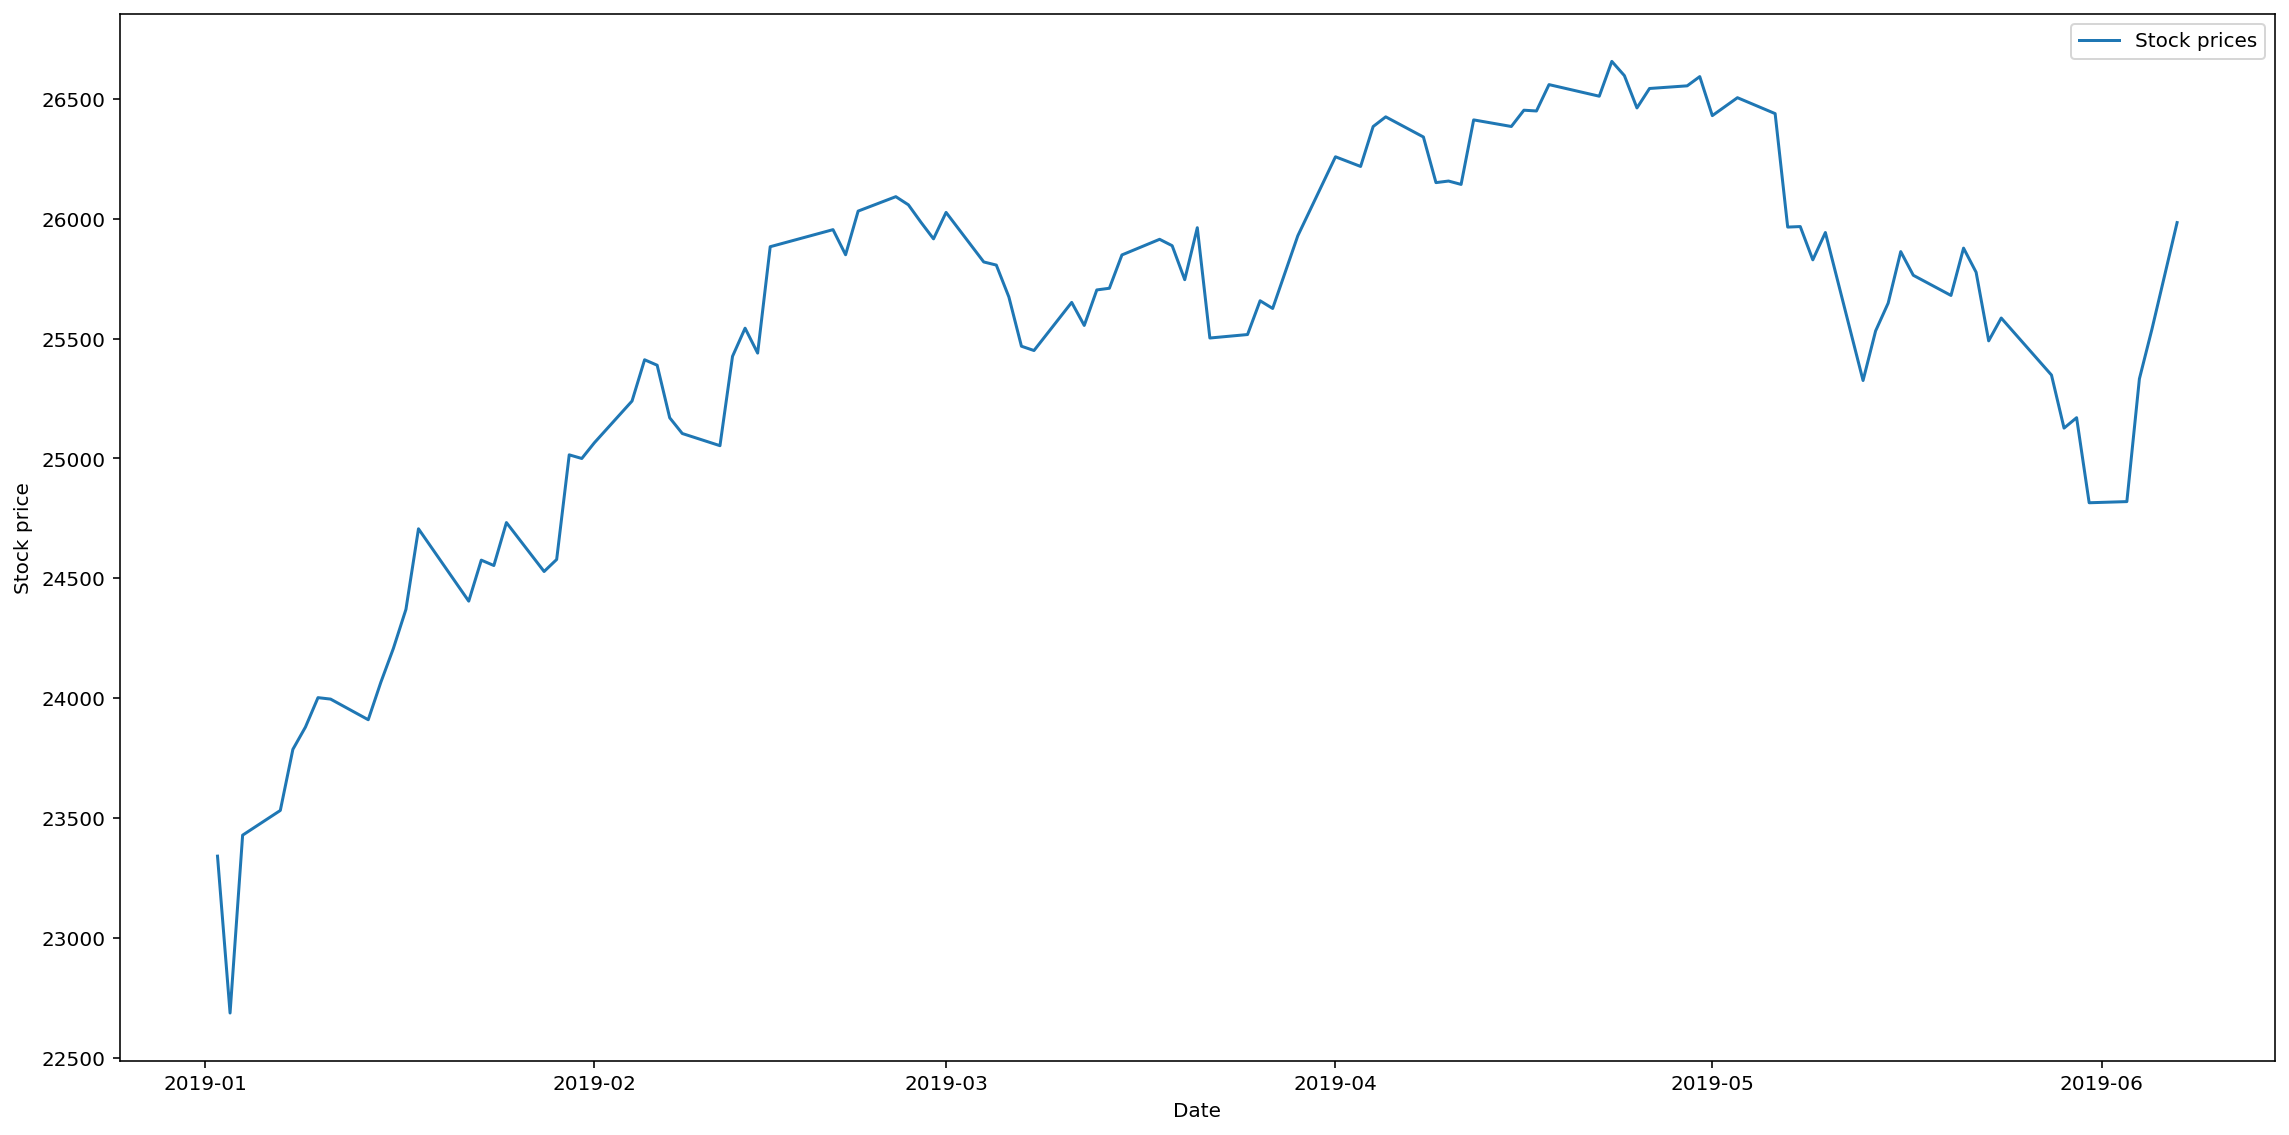

In [30]:
plot_strategy(evaluator, ticker_name='DJI', start='2019-01-01', end='2019-12-31')

## Cisco

In [31]:
%%time
best_individual = find_best_strategy(ticker_name='CSCO', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean     	std   
0  	1000  	-31.9295	17.6317	-0.140605	6.6464
1  	635   	-19.2549	17.6317	3.56961  	4.73951
2  	649   	-18.615 	18.6453	5.96399  	4.77579
3  	617   	-15.6227	18.6453	8.43611  	4.91538
4  	691   	-28.864 	19.843 	10.567   	5.37421
5  	666   	-8.92825	19.7998	12.9196  	4.65173
6  	655   	-28.864 	19.8397	14.2244  	4.72202
7  	648   	-12.2282	19.9605	14.7926  	4.5436 
Net profit of buy and hold: 17.551374999999997
Running backtesting ...
Best individual: [1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1]
Best average net profit: 1.8124380490900092
CPU times: user 5min 43s, sys: 474 ms, total: 5min 44s
Wall time: 5min 44s


In [32]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')
results['CSCO'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[2, 37, 94], [14, 5]]
Net profit of strategy: -3.652625
Net profit of buy and hold: 5.462050
Percentage profit of strategy: -8.963497%
Percentage profit of buy and hold: 13.403804%
Number of buy signals: 10
Number of sell signals: 10


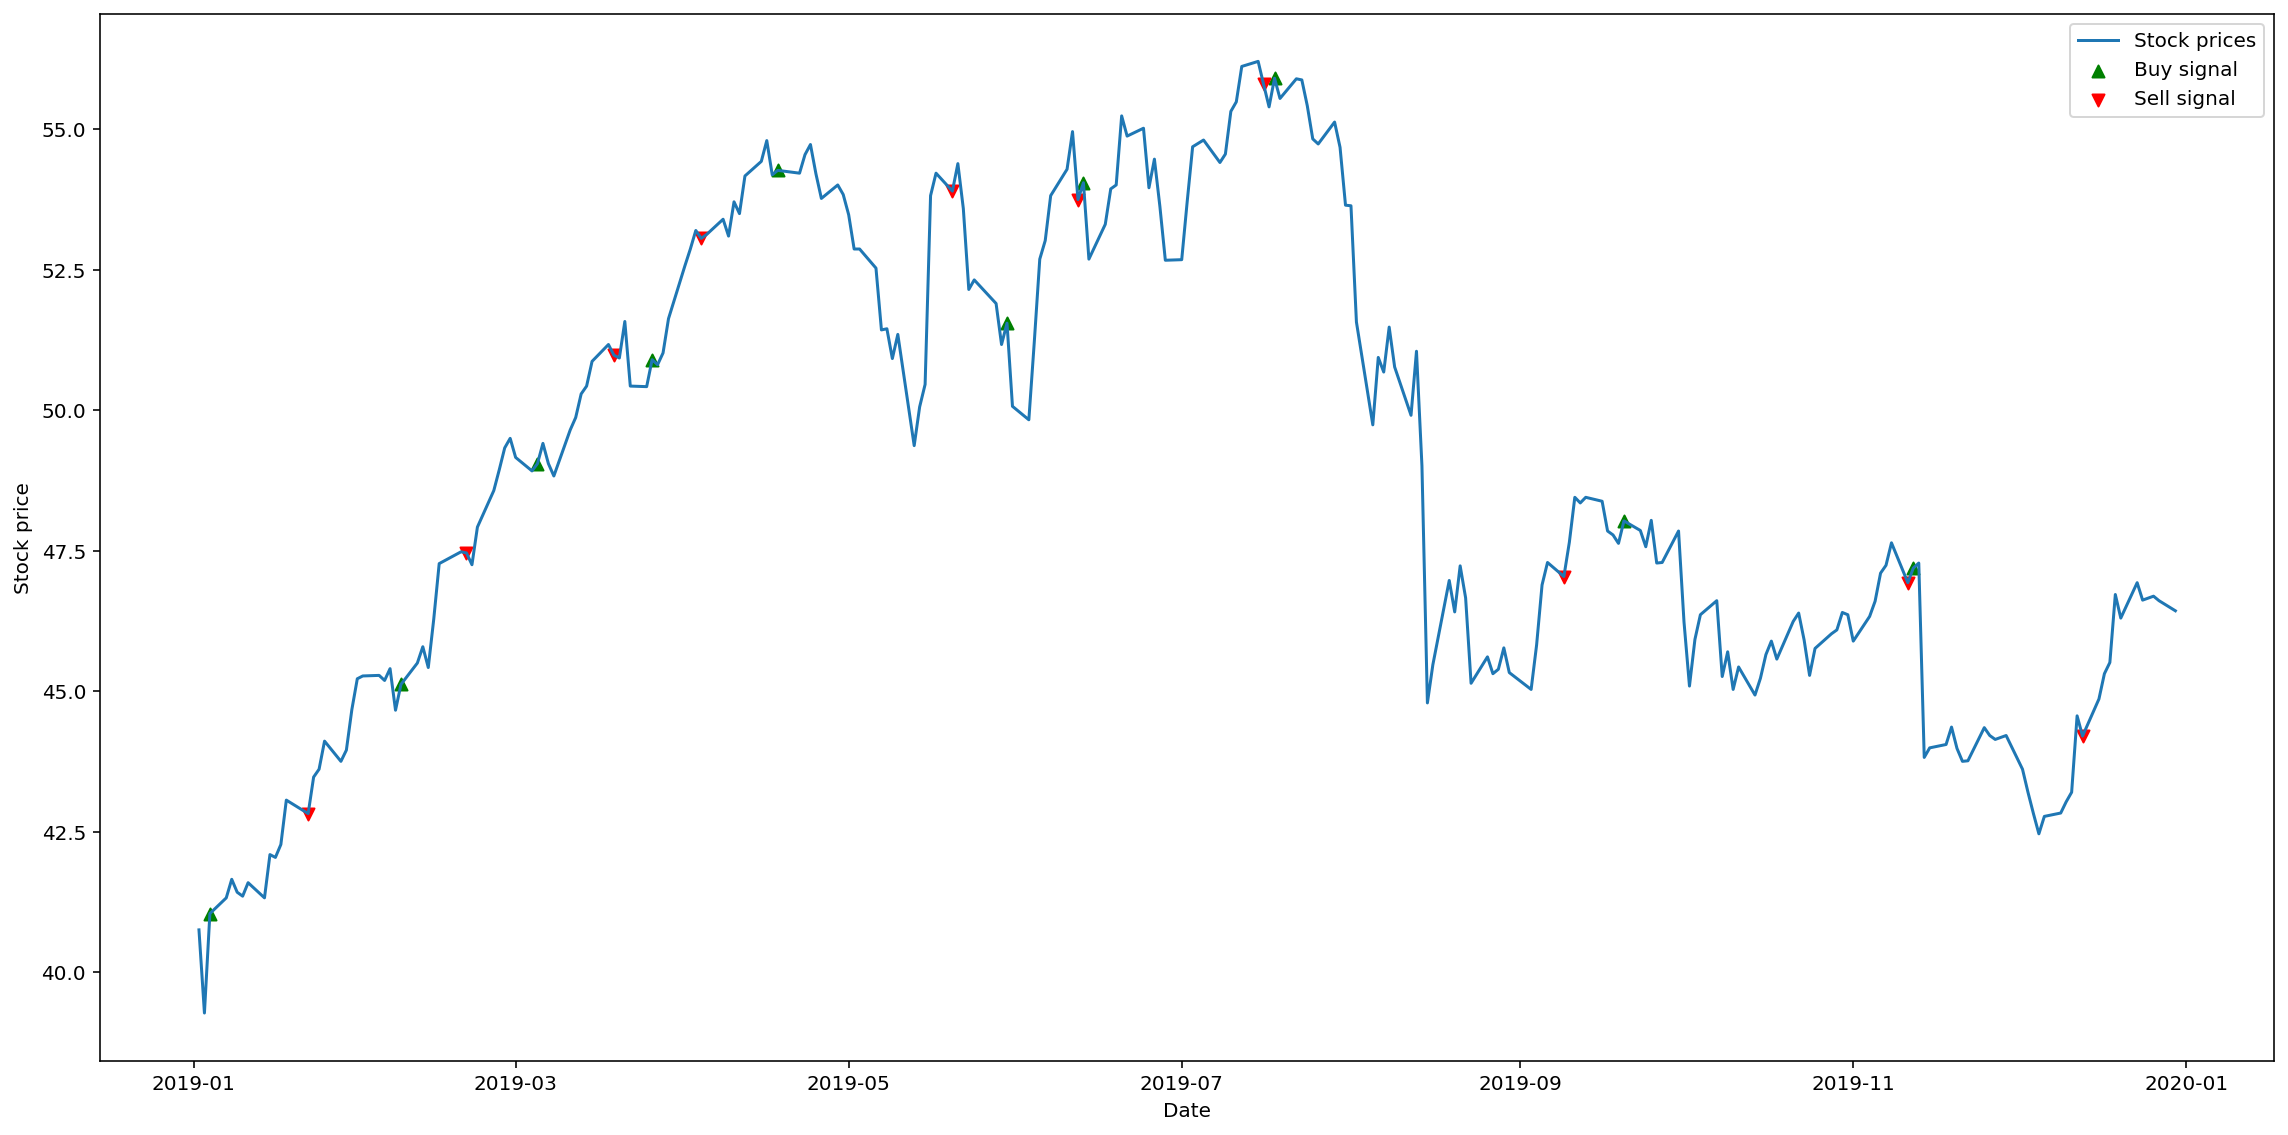

In [33]:
plot_strategy(evaluator, ticker_name='CSCO', start='2019-01-01', end='2019-12-31')

## DowDuPont

In [34]:
%%time
best_individual = find_best_strategy(ticker_name='DD', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max   	mean    	std    
0  	1000  	-77.9756	28.685	-16.4197	14.9692
1  	635   	-72.7027	28.685	-6.32345	10.5873
2  	649   	-73.1992	28.685	-0.369782	9.79375
3  	617   	-72.7027	28.685	4.16566  	10.6242
4  	691   	-74.5736	28.685	8.27924  	10.6028
5  	666   	-51.3598	28.685	11.399   	10.3018
6  	655   	-75.2348	37.019	13.7779  	11.6102
7  	648   	-74.5736	35.2552	16.841   	11.2001
Net profit of buy and hold: 12.261875000000003
Running backtesting ...
Best individual: [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]
Best average net profit: 0.8310932973510023
CPU times: user 5min 39s, sys: 469 ms, total: 5min 40s
Wall time: 5min 40s


In [35]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='DD', start='2019-01-01', end='2019-12-31')
results['DD'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[24, 54, 120], [189], [28, 7]]
Net profit of strategy: 0.000000
Net profit of buy and hold: -13.107875
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: -17.722925%
Number of buy signals: 0
Number of sell signals: 0


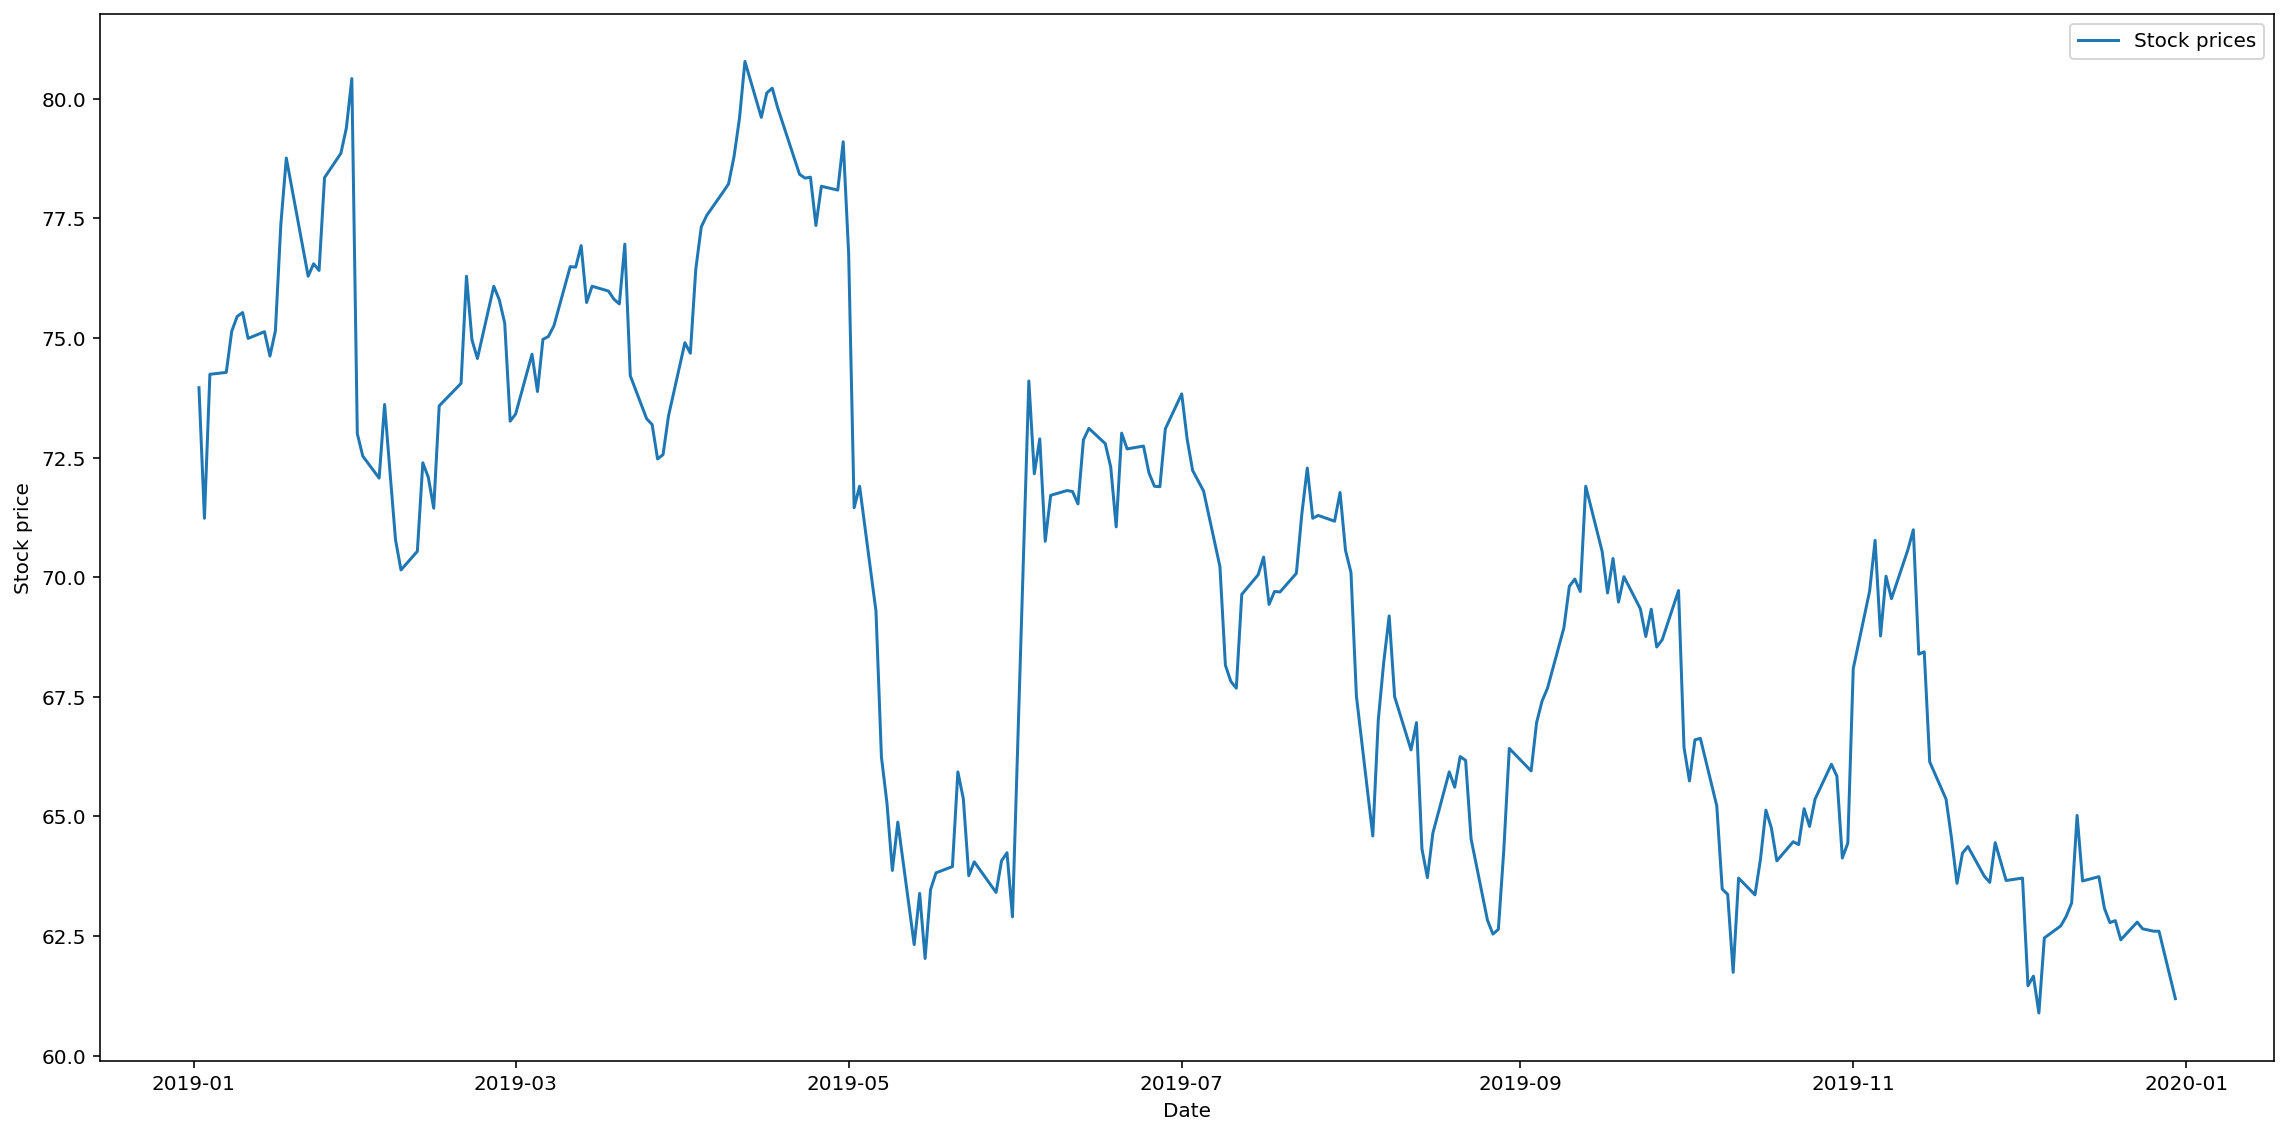

In [36]:
plot_strategy(evaluator, ticker_name='DD', start='2019-01-01', end='2019-12-31')

## JPMorgan Chase

In [37]:
%%time
best_individual = find_best_strategy(ticker_name='JPM', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std   
0  	1000  	-87.7597	49.1132	-1.36443	17.823
1  	635   	-46.7498	42.0265	10.4465 	11.4798
2  	649   	-32.0461	42.0265	17.0702 	10.5392
3  	617   	-74.7823	42.3678	20.6587 	11.1357
4  	691   	-73.4382	49.9739	22.4219 	12.7428
5  	666   	-71.2428	49.9739	23.9744 	14.499 
6  	655   	-71.2428	49.9739	26.7419 	13.8698
7  	648   	-72.742 	49.9739	28.3435 	14.9836
Net profit of buy and hold: 35.241775
Running backtesting ...
Best individual: [0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]
Best average net profit: 0.3975348754096251
CPU times: user 6min 19s, sys: 523 ms, total: 6min 20s
Wall time: 6min 20s


In [38]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='JPM', start='2019-01-01', end='2019-12-31')
results['JPM'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[33, 41, 127], [93], [3, 5]]
Net profit of strategy: 0.000000
Net profit of buy and hold: 40.648000
Percentage profit of strategy: 0.000000%
Percentage profit of buy and hold: 43.339375%
Number of buy signals: 0
Number of sell signals: 0


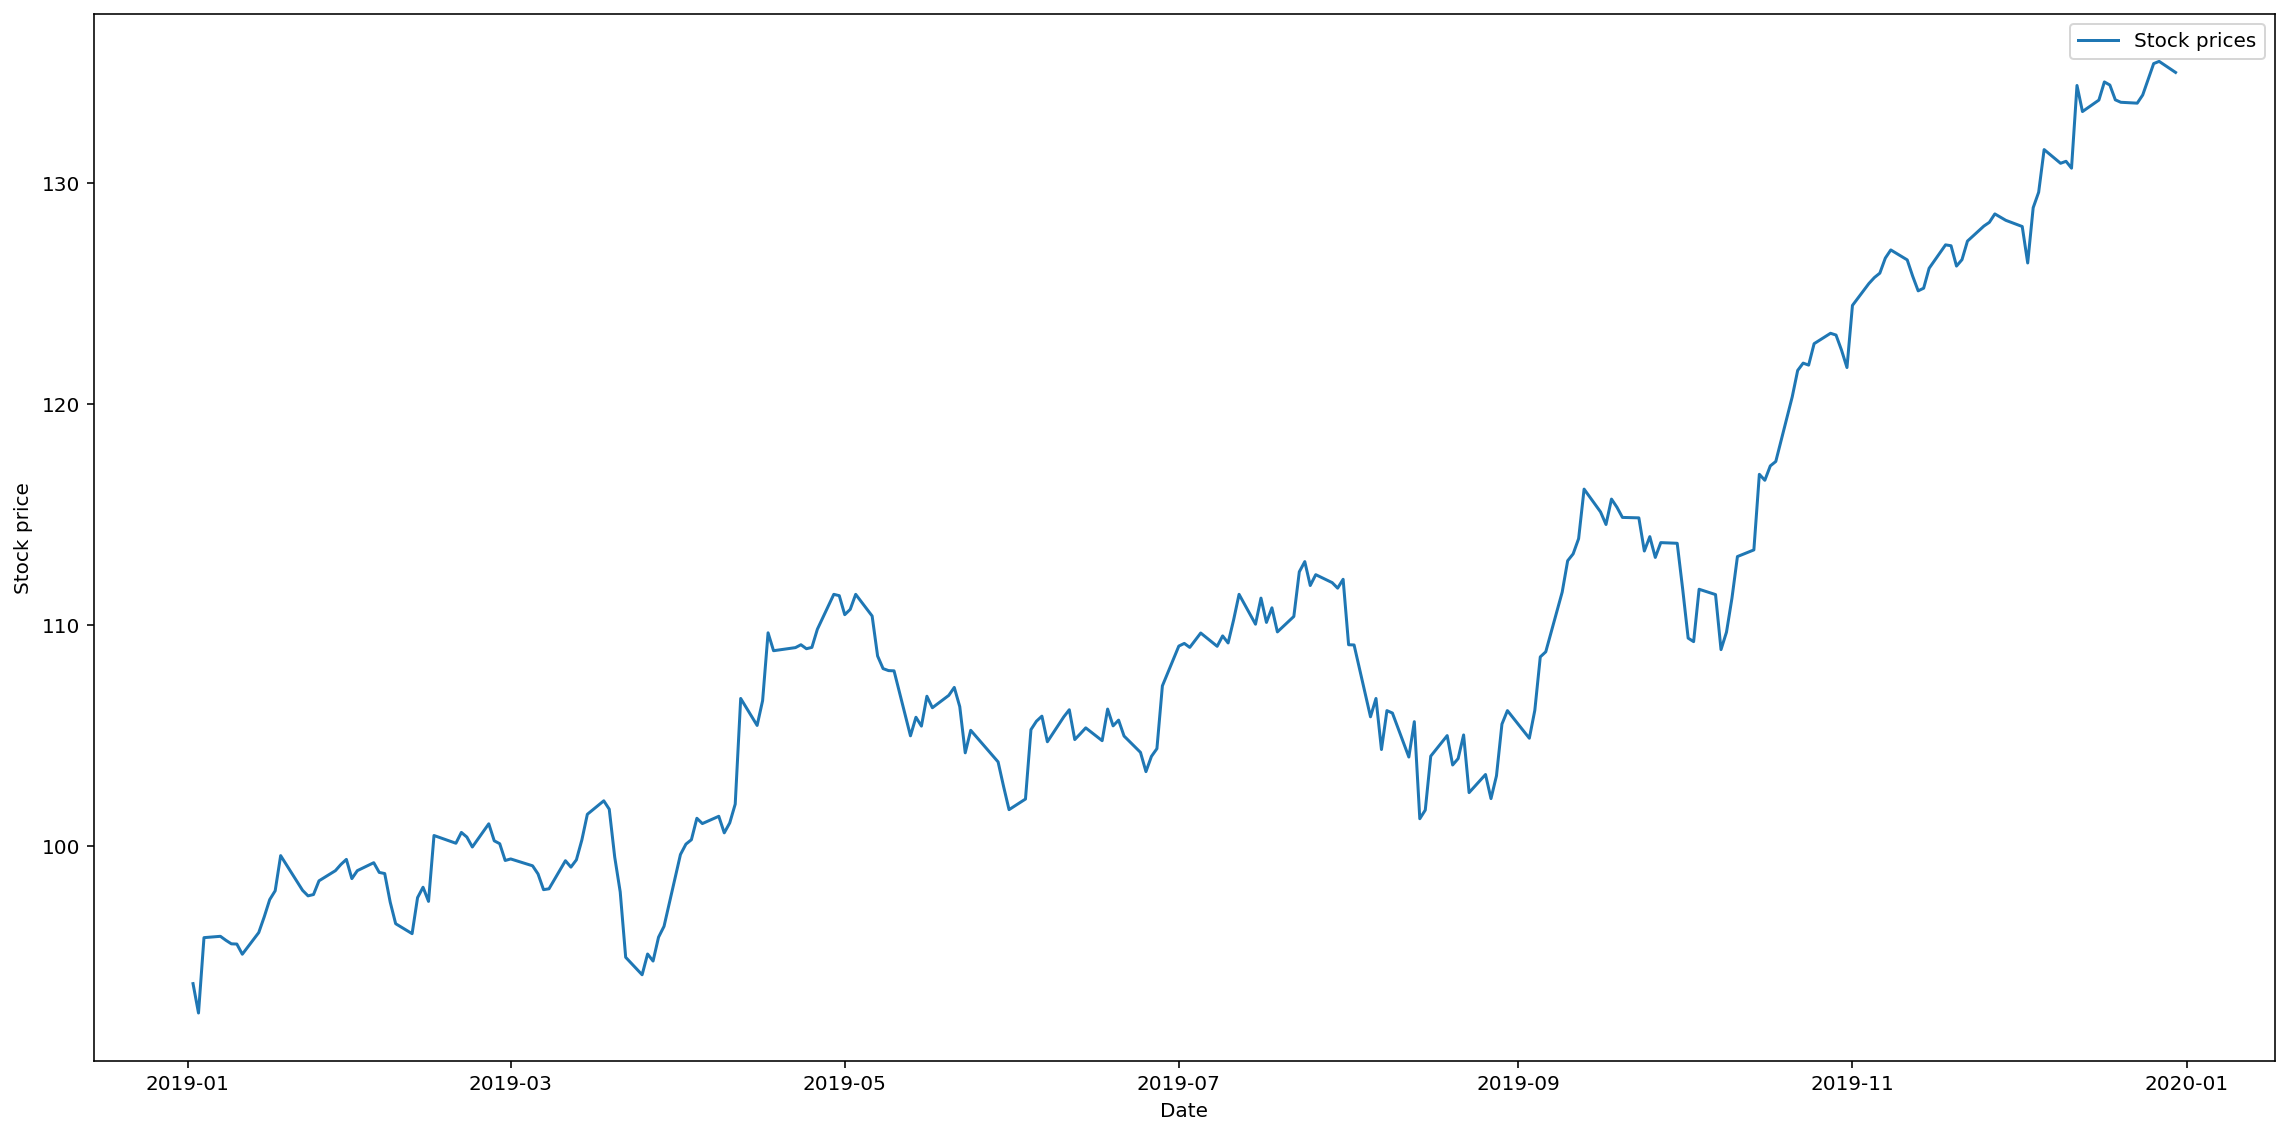

In [39]:
plot_strategy(evaluator, ticker_name='JPM', start='2019-01-01', end='2019-12-31')

## Microsoft

In [40]:
%%time
best_individual = find_best_strategy(ticker_name='MSFT', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-87.2091	50.5036	-12.0889	19.3993
1  	635   	-87.2022	50.5036	0.634674	16.9002
2  	649   	-49.9257	50.5036	10.8785 	18.3727
3  	617   	-84.9165	52.9778	22.1443 	19.0771
4  	691   	-83.9853	52.9778	30.4357 	17.9755
5  	666   	-47.5132	52.9778	35.8673 	16.3119
6  	655   	-86.9548	52.9778	38.0431 	17.8251
7  	648   	-46.1631	53.8665	40.5842 	16.6991
Net profit of buy and hold: 47.639275000000005
Running backtesting ...
Best individual: [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Best average net profit: 5.407700667215155
CPU times: user 5min 6s, sys: 388 ms, total: 5min 6s
Wall time: 5min 7s


In [41]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')
results['MSFT'].append([percentage_profit, percentage_profit_bh])

Active rules: ['RSI', 'BollingerBaender']
Active rules' parameters: [[6, 45, 75], [59, 7]]
Net profit of strategy: 32.919125
Net profit of buy and hold: 56.851975
Percentage profit of strategy: 33.298731%
Percentage profit of buy and hold: 57.507561%
Number of buy signals: 6
Number of sell signals: 6


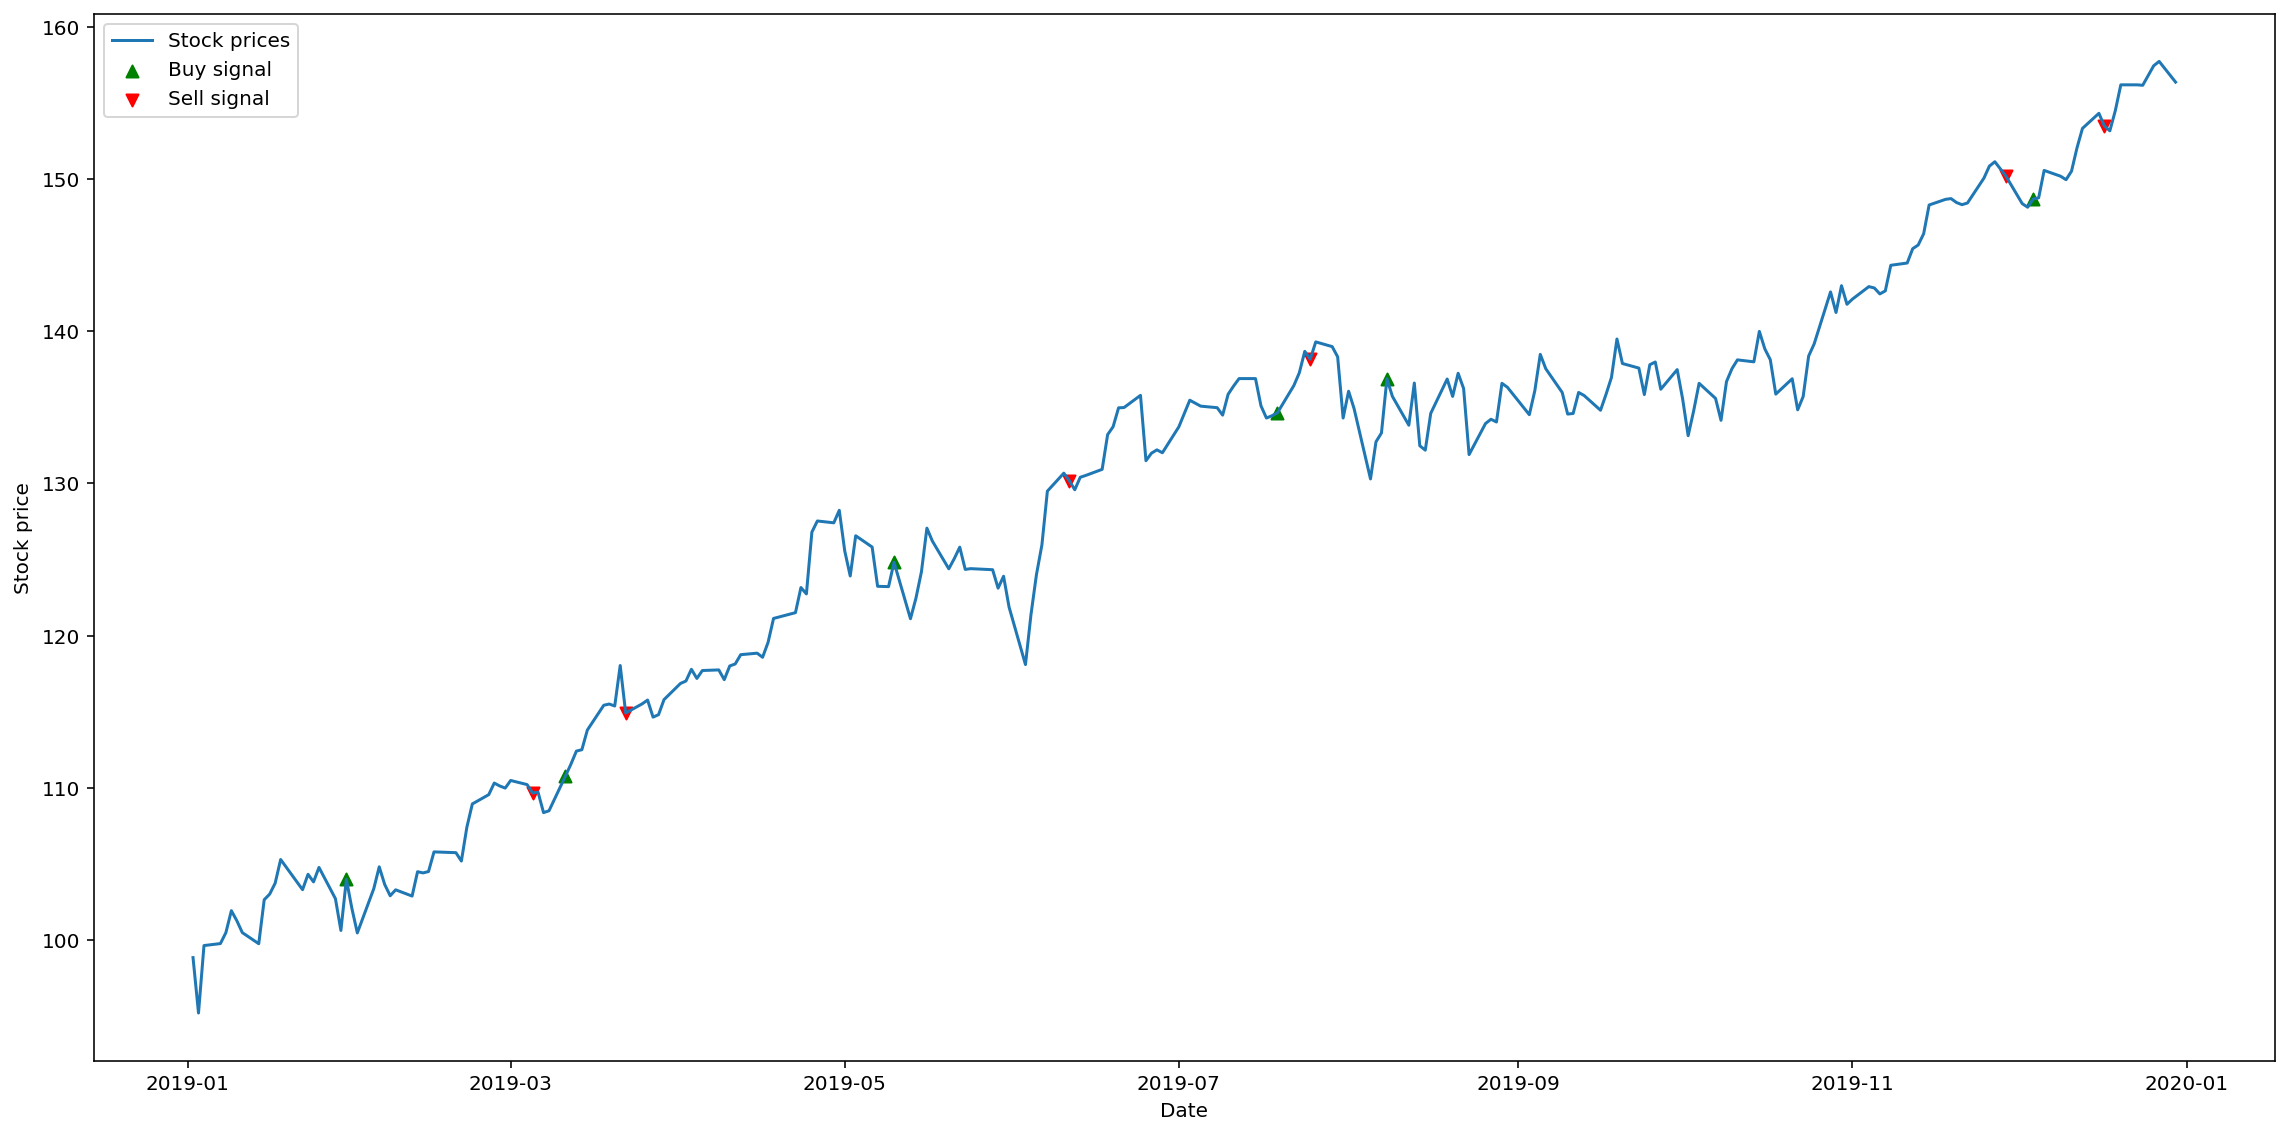

In [42]:
plot_strategy(evaluator, ticker_name='MSFT', start='2019-01-01', end='2019-12-31')

## Nike

In [43]:
%%time
best_individual = find_best_strategy(ticker_name='NKE', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max    	mean    	std    
0  	1000  	-77.3715	25.4164	-13.5088	14.7887
1  	635   	-73.9857	26.714 	-3.74923	10.5189
2  	649   	-43.4054	29.8909	2.82148 	9.67247
3  	617   	-33.3151	32.4743	8.68219 	9.67279
4  	691   	-74.4536	33.1303	13.3977 	10.7162
5  	666   	-29.8106	33.5175	18.6754 	9.31709
6  	655   	-29.0747	33.5175	21.9738 	8.8471 
7  	648   	-27.4552	34.7306	24.0504 	8.72189
Net profit of buy and hold: 13.604675
Running backtesting ...
Best individual: [1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
Best average net profit: 0.0
CPU times: user 5min 35s, sys: 414 ms, total: 5min 36s
Wall time: 5min 36s


In [44]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='NKE', start='2016-01-01', end='2018-12-31')
results['NKE'].append([percentage_profit, percentage_profit_bh])

Active rules: ['STO', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[198], [41, 11, 46], [247], [20, 4]]
Net profit of strategy: 34.730650
Net profit of buy and hold: 13.604675
Percentage profit of strategy: 59.777367%
Percentage profit of buy and hold: 23.415964%
Number of buy signals: 11
Number of sell signals: 11


KeyError: Timestamp('2019-01-02 00:00:00')

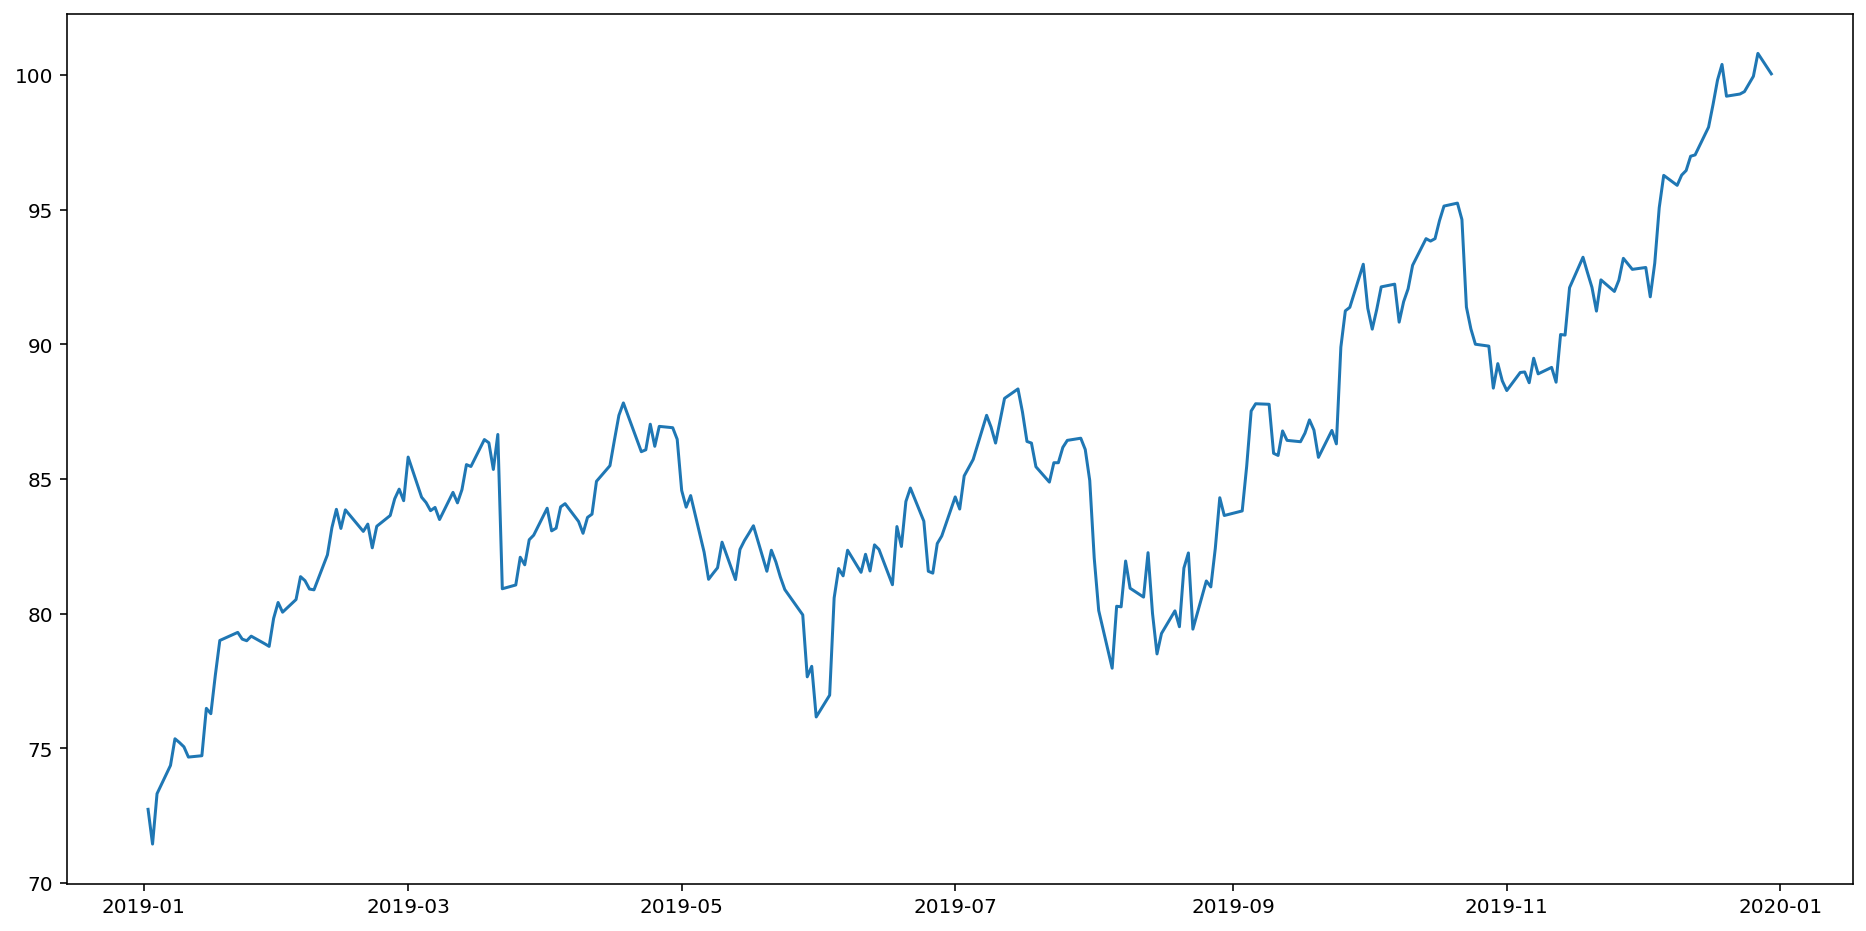

In [45]:
plot_strategy(evaluator, ticker_name='NKE', start='2019-01-01', end='2019-12-31')

## UnitedHealth

In [46]:
%%time
best_individual = find_best_strategy(ticker_name='UNH', start='2016-01-01', end='2018-12-31', ngen=7)

Running genetic algorithm ...
gen	nevals	min     	max   	mean   	std    
0  	1000  	-91.4831	130.96	6.19353	38.3112
1  	635   	-74.1666	130.96	32.2556	36.8604
2  	649   	-73.4602	138.676	55.4179	40.9012
3  	617   	-43.5825	151.355	80.2648	41.2183
4  	691   	-81.9659	151.355	99.5413	40.9421
5  	666   	-73.4602	156.291	112.569	36.5325
6  	655   	-60.1216	156.291	119.526	32.83  
7  	648   	-48.8796	157.071	120.262	34.4768
Net profit of buy and hold: 130.18222500000002
Running backtesting ...
Best individual: [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]
Best average net profit: 6.9351372843199615
CPU times: user 5min 57s, sys: 431 ms, total: 5min 57s
Wall time: 5min 57s


In [47]:
evaluator, percentage_profit, percentage_profit_bh = print_test_results(best_individual, ticker_name='UNH', start='2019-01-01', end='2019-12-31')
results['UNH'].append([percentage_profit, percentage_profit_bh])

Active rules: ['ExponentialMovingAverage', 'RSI', 'ROC', 'BollingerBaender']
Active rules' parameters: [[169], [3, 57, 95], [252], [2, 7]]
Net profit of strategy: 38.029675
Net profit of buy and hold: 52.403650
Percentage profit of strategy: 16.086322%
Percentage profit of buy and hold: 22.166427%
Number of buy signals: 14
Number of sell signals: 14


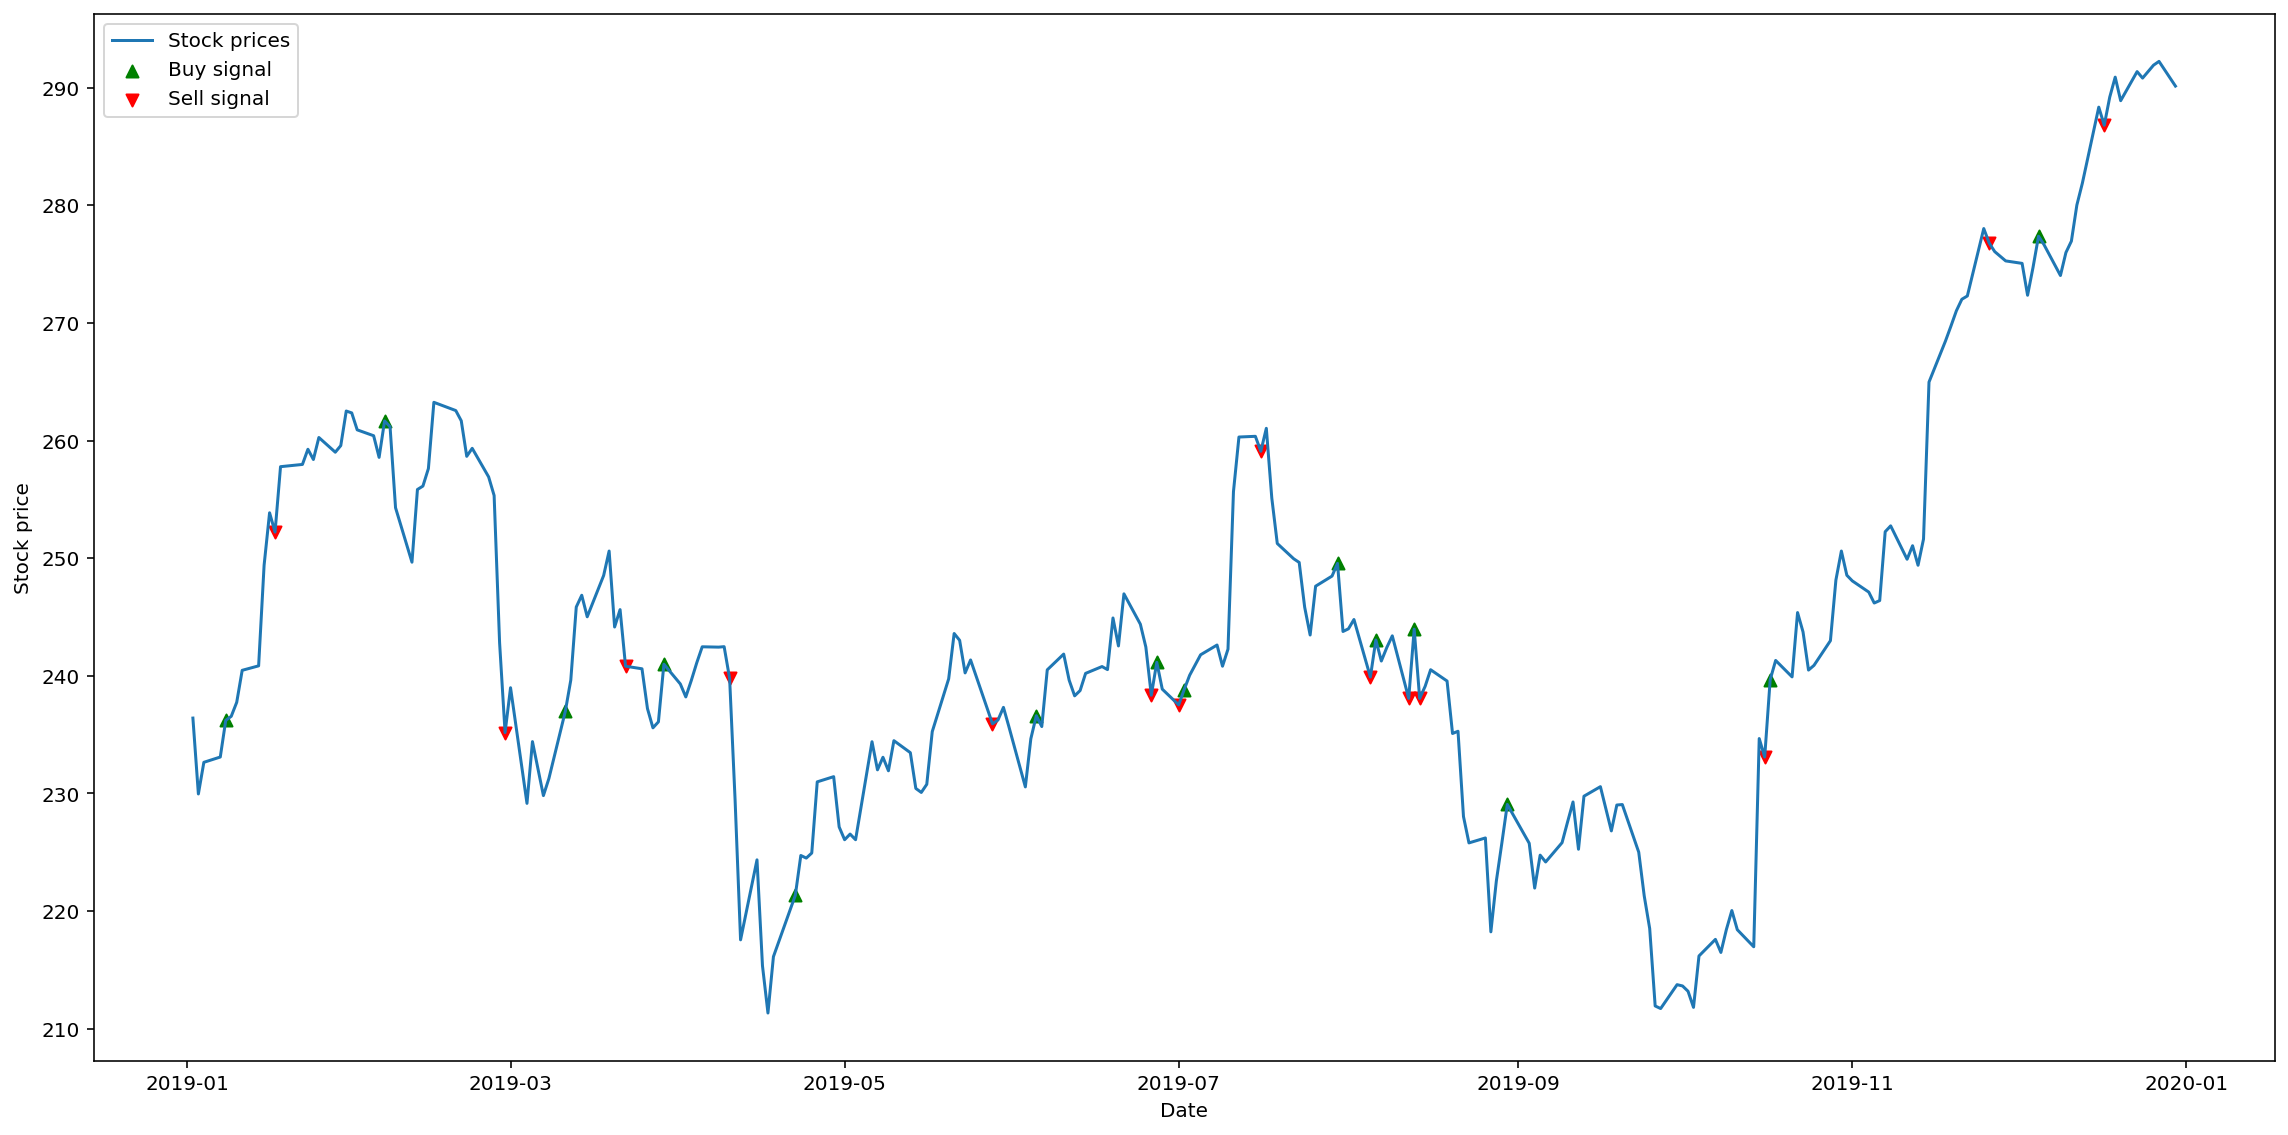

In [48]:
plot_strategy(evaluator, ticker_name='UNH', start='2019-01-01', end='2019-12-31')

# Results

In [49]:
results_df = pd.DataFrame(results)
results_df

,EXS1.DE,ADS.DE,ALV.DE,BAS.DE,DBK.DE,DTE.DE,SAP.DE,DJI,CSCO,DD,JPM,MSFT,NKE,UNH
0,"[20.759241992101728, 24.010750329091714]","[21.56393686217342, 49.514831221262746]","[11.211317460317458, 31.210999999999995]","[9.071470878578591, 10.745261599210268]","[33.55583214793723, -2.060810810810815]","[12.257933436532502, 12.470588235294116]","[11.642737195633918, 28.72984886649873]","[0.0, 10.796113655545895]","[-8.963496932515238, 13.403803680981593]","[0.0, -17.72292455381287]","[0.0, 43.339375199914684]","[33.29873052801936, 57.507561197653246]","[59.777366609294305, 23.415963855421687]","[16.086322490588422, 22.166426970094328]"


In [50]:
ps_results = list()
bh_results = list()
for col in results_df.columns:
    results_df[col].apply(lambda result: ps_results.append(result[0]))
    results_df[col].apply(lambda result: bh_results.append(result[1]))

In [51]:
np.mean(ps_results)

15.732956619190121

In [52]:
np.mean(bh_results)

21.96627067473895